# COVID-19 Data Analysis and Forecasting

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney/Covid_Analysis

## Introduction

### Problem and Purpose

#### This project will use forecasting to model Covid-19 deaths  based on current hospitalization, ventilator, and death data. I will be using API html links to bring in up to date data regularly. This project will use supervised learning in the form of SARIMA and SARIMAX in order to create time series death forecasts.

#### The purpose of this analysis is to provide an accurate forecast of Covid-19 related deaths as 2021 progresses.
#### Our challenges are -
#### * 1. Create multiple forecasts by creating forecasts for specific states
#### * 2. Build a forecast for the United States as a whole
#### * 3. Provide insights as to the urgency of making changes to how we are operating as a country

### The Data
#### The Covid Tracking Project was organized by the news agency The Atlantic early in 2020 in an effort to provide as much data on the pandemic as possible. Coordination of state by state Covid data required building working relationships with state officials to obtain relevant state information. Above are links to the project that can provide further information regarding Covid-19. Additionally, it is worth noting that the project is coming to its end at the beginning of March 2021 as a result of improvements to Federal collection of data. 

In [9]:
open_links = False

In [10]:
import webbrowser

if open_links == True:
    webbrowser.open("https://covidtracking.com/")
    webbrowser.open("https://covidtracking.com/data/api")

### Chosen States

### Custom Libraries

In [2]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload
from Cust_Func import *

### Standard Libraries

In [3]:
from tensorflow.random import set_seed
import numpy as np

set_seed(42)
np.random.seed(42) 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
%matplotlib inline
import functools
from jupyter_plotly_dash import JupyterDash
import datetime as dt
from datetime import date
from datetime import datetime, timedelta
import pandas_datareader as pdr
import holidays

In [5]:
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, TensorBoard

In [6]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [7]:
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

### Custom Libraries

## Explore Data

### Create New DataFrame

In [11]:
# set to true to fetch new data. 
get_data = False

In [12]:
if get_data == True:
    df_states = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv',index_col='date',parse_dates=True)
    df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)
    df_states.to_csv('StateData.csv')
    df_whole_US.to_csv('USA.csv')
else:
    df_states = pd.read_csv('StateData.csv', index_col='date', parse_dates=True)
    df_whole_US = pd.read_csv('USA.csv', index_col='date', parse_dates=True)

In [258]:
df_states.head()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2021-02-12,AK,54282.0,NaN,NaN,NaN,totalTestsViral,1584548.0,35.0,1230.0,NaN,...,54282,2,3,36a7bd363d7e7e136b514bdd9b6e1f20c4ee03e3,0,0,0,0,0,NaN
2021-02-12,AL,478667.0,103040.0,1842516.0,NaN,totalTestsPeopleViral,2218143.0,1267.0,44148.0,NaN,...,2321183,159,242,ff04dbca52ac8a4d86e024cc0103bcd7f40bafb1,0,0,0,0,0,NaN
2021-02-12,AR,311608.0,64580.0,2322916.0,NaN,totalTestsViral,2569944.0,712.0,14278.0,258.0,...,2634524,13,23,58c4a514c40fb89a1ec4ace6165c7865cca79390,0,0,0,0,0,NaN
2021-02-12,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,NaN,...,2140,0,0,062c1f214e9d596a07bd505ce605e8819a958e0c,0,0,0,0,0,NaN
2021-02-12,AZ,793532.0,53218.0,2864855.0,NaN,totalTestsViral,7140917.0,2396.0,55413.0,705.0,...,3658387,172,141,5c92b090358c959185311493808db36779928457,0,0,0,0,0,NaN


In [259]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19485 entries, 2021-02-12 to 2020-01-13
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        19485 non-null  object 
 1   positive                     19296 non-null  float64
 2   probableCases                8390 non-null   float64
 3   negative                     15509 non-null  float64
 4   pending                      2024 non-null   float64
 5   totalTestResultsSource       19485 non-null  object 
 6   totalTestResults             19383 non-null  float64
 7   hospitalizedCurrently        16119 non-null  float64
 8   hospitalizedCumulative       12017 non-null  float64
 9   inIcuCurrently               10568 non-null  float64
 10  inIcuCumulative              3516 non-null   float64
 11  onVentilatorCurrently        8386 non-null   float64
 12  onVentilatorCumulative       1201 non-null   float64
 13 

In [260]:
df_whole_US.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
date,,,,,,,,,,,,,,,,,,,,,
2021-02-12,56,27266230.0,122400369.0,9434.0,71504.0,839119.0,14775.0,43389.0,4849.0,4126.0,...,2021-02-12T24:00:00Z,NaN,0,0,5418,2345,567071,100570,1816007,c402515c19b77ba9243af172a9c5799f13cd8e56
2021-02-11,56,27165660.0,121833298.0,11981.0,74225.0,836774.0,15190.0,43291.0,4970.0,4113.0,...,2021-02-11T24:00:00Z,NaN,0,0,3873,2460,588596,102417,1872586,9e06c1c2bc7906114b2dfb77c02fac6a1ff15c7c
2021-02-10,56,27063243.0,121244702.0,12079.0,76979.0,834314.0,15788.0,43184.0,5121.0,4106.0,...,2021-02-10T24:00:00Z,NaN,0,0,3445,3226,385138,95194,1393156,a821a2f23aaee791d155df7e3a2755b31c1bdd32
2021-02-09,56,26968049.0,120859564.0,10516.0,79179.0,831088.0,16129.0,43000.0,5216.0,4092.0,...,2021-02-09T24:00:00Z,NaN,0,0,2795,3144,492086,92986,1502502,0ad7fb536eb23f95461201090c436ec7f76ac052
2021-02-08,56,26875063.0,120367478.0,12114.0,80055.0,827944.0,16174.0,42833.0,5260.0,4080.0,...,2021-02-08T24:00:00Z,NaN,0,0,1309,1638,454325,77737,1434298,7abf3026a5235e6761608e2971df85adb1c9bb18


### Plot of Ventilators and Deaths for Each State

In [261]:
df_states.columns.unique

<bound method Index.unique of Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestRe

In [262]:
df_states.isnull().sum()

state                              0
positive                         189
probableCases                  11095
negative                        3976
pending                        17461
totalTestResultsSource             0
totalTestResults                 102
hospitalizedCurrently           3366
hospitalizedCumulative          7468
inIcuCurrently                  8917
inIcuCumulative                15969
onVentilatorCurrently          11099
onVentilatorCumulative         18284
recovered                       5493
dataQualityGrade                1337
lastUpdateEt                     586
dateModified                     586
checkTimeEt                      586
death                            871
hospitalized                    7468
dateChecked                      586
totalTestsViral                 6574
positiveTestsViral             11983
negativeTestsViral             14987
positiveCasesViral              6151
deathConfirmed                 10408
deathProbable                  12533
t

In [263]:
# columns to keep in dataframe
columns = ['state','death','inIcuCurrently','onVentilatorCurrently','positive','hospitalizedCurrently','deathIncrease']

In [264]:
for col in columns:
    df_states[col] = df_states[col].fillna(0)

In [265]:
df_states = sort_and_clean_df(dataframe=df_states, target_columns=columns, percent_data_threshold=.05)

In [266]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19485 entries, 2020-01-13 to 2021-02-12
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  19485 non-null  object 
 1   death                  19485 non-null  float64
 2   inIcuCurrently         19485 non-null  float64
 3   onVentilatorCurrently  19485 non-null  float64
 4   positive               19485 non-null  float64
 5   hospitalizedCurrently  19485 non-null  float64
 6   deathIncrease          19485 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


In [267]:
df_states.iloc[-50:].sort_values(by='death',ascending=False)
# # only graph the top 7 
# that keep state ventilator data

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2021-02-12,CA,46002.0,2930.0,0.0,3381615.0,10505.0,546
2021-02-12,TX,40095.0,2582.0,0.0,2541845.0,8607.0,324
2021-02-12,NY,36882.0,1358.0,941.0,1512690.0,7068.0,139
2021-02-12,FL,29061.0,0.0,0.0,1781450.0,4825.0,190
2021-02-12,PA,22959.0,496.0,286.0,888256.0,2548.0,99
2021-02-12,NJ,22393.0,525.0,336.0,740062.0,2565.0,64
2021-02-12,MI,16027.0,293.0,123.0,628012.0,1024.0,8
2021-02-12,GA,15708.0,0.0,0.0,958985.0,3362.0,195
2021-02-12,MA,15358.0,300.0,180.0,553812.0,1223.0,89


In [268]:
df_states['state'].unique() # list of states to iterate through

array(['WA', 'MA', 'VA', 'FL', 'NJ', 'NE', 'IN', 'MI', 'RI', 'WY', 'NY',
       'PA', 'TX', 'VT', 'WI', 'IL', 'HI', 'NC', 'CO', 'CA', 'AZ', 'GA',
       'NH', 'OR', 'SC', 'MD', 'DC', 'NM', 'TN', 'OH', 'NV', 'IA', 'KY',
       'KS', 'AR', 'DE', 'AK', 'MN', 'WV', 'ID', 'LA', 'CT', 'AL', 'MO',
       'ME', 'MT', 'MS', 'UT', 'SD', 'ND', 'OK', 'GU', 'AS', 'MP', 'VI',
       'PR'], dtype=object)

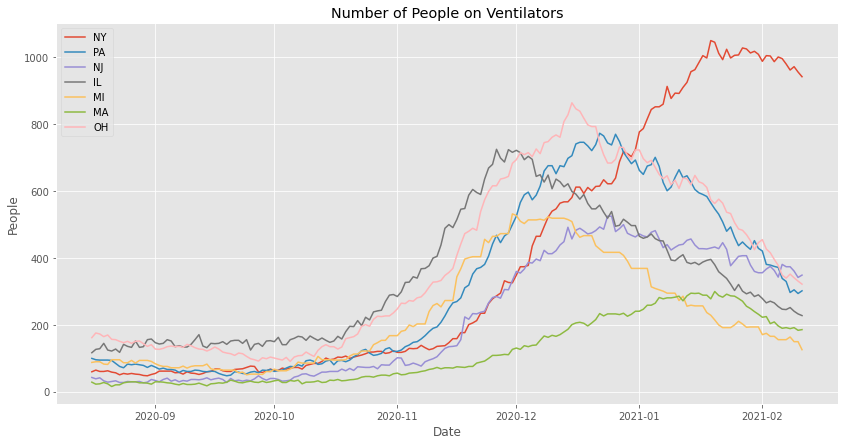

In [269]:
# for loop iterates through shortened list and prints ventilator usage
# for the trailing 180 day period. 
state_postal = ['NY', 'PA', 'NJ','IL','MI','MA','OH']

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state]['onVentilatorCurrently'].sort_index()
    df_plot = df_individual.iloc[(df_individual.index.argmax()-180):(df_individual.index.argmax())]
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of People on Ventilators')
    plt.xlabel('Date')
    plt.ylabel('People')
    plt.legend();

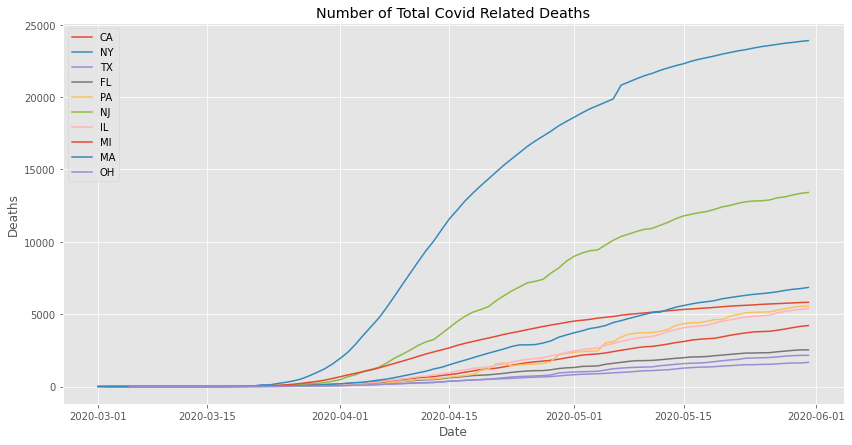

In [424]:
# same as above graph - all states have death data, this is a graph of the
# states with the highest covid mortality 
state_postal = ['CA', 'NY', 'TX', 'FL', 'PA', 'NJ','IL','MI','MA','OH'] # highest death count states
# some do not have ventilator data reported. 

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state].death.sort_index()
    df_plot = df_individual.loc['2020-03':'2020-05']
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of Total Covid Related Deaths')
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.legend();

### Plot Alaska Death Count

In [271]:
df_AK = df_states[df_states['state']=='AK'] # just look at Alaska for now 

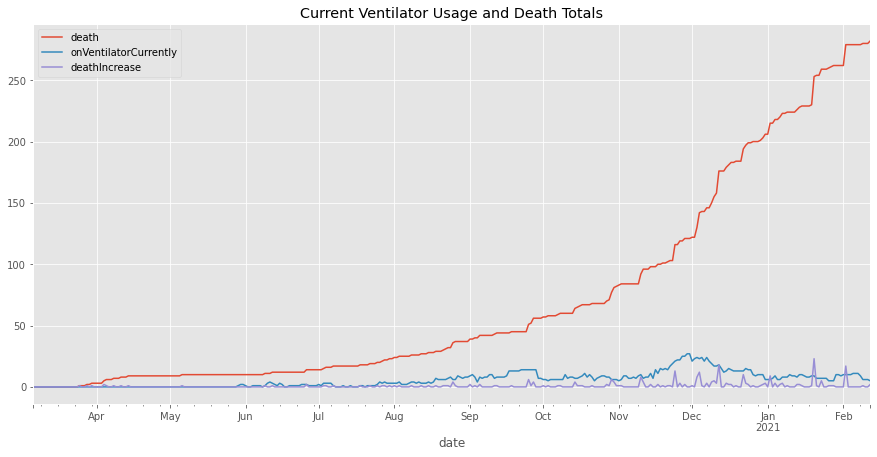

In [272]:
fig = plt.figure(figsize=(15,7));

df_AK['death'].plot(legend=True,title='Current Ventilator Usage and Death Totals');
df_AK['onVentilatorCurrently'].plot(legend=True);
df_AK['deathIncrease'].plot(legend=True);

Ventilator usage in Alaska peaks right before the end of December. deathIncrease is the rate of death, or 'volume' of death. Spikes in that line correspond to a steeper increase in deaths along the red trend. 

# Modeling and Forecasts

### Alaska SARIMA Model - Initial Modeling

In [273]:
df_AK = df_AK.sort_index()

In [274]:
df_AK = df_AK.dropna(subset=['death'])
df_AK = df_AK.dropna(subset=['onVentilatorCurrently'])

In [275]:
df_alaska = pd.DataFrame(df_AK)

In [276]:
print(df_alaska.index.min())
print(df_alaska.index.max())
print('Length of dataframe: ' , len(df_alaska))

2020-03-06 00:00:00
2021-02-12 00:00:00
Length of dataframe:  344


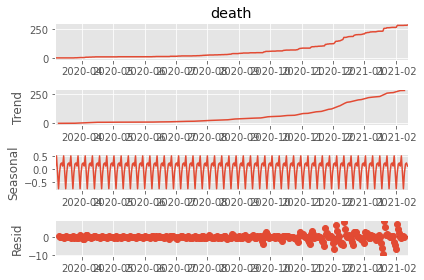

In [277]:
sd(df_alaska['death'], model='additive').plot(); # alaska = seasonal

In [278]:
stepwise_fit = auto_arima(df_alaska['death'],start_p=0,start_q=0,max_p=10,
                          max_q=10, seasonal=True, seasonal_test='ocsb', maxiter=75, method='lbfgs',
                          n_jobs=-1,stepwise=True)

In [279]:
model = SARIMAX(df_alaska['death'], order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  death   No. Observations:                  344
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -771.585
Date:                Tue, 16 Feb 2021   AIC                           1547.170
Time:                        08:24:46   BIC                           1554.840
Sample:                    03-06-2020   HQIC                          1550.225
                         - 02-12-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9661      0.010    -94.202      0.000      -0.986      -0.946
sigma2         5.2930      0.095     55.531      0.000       5.106       5.480
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             19731.69
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             102.42   Skew:                             5.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [280]:
# dont forget get_predict
predictions_AK = model.get_forecast(30)

In [281]:
predictions_AK.predicted_mean

2021-02-13    283.716071
2021-02-14    285.432141
2021-02-15    287.148212
2021-02-16    288.864283
2021-02-17    290.580353
2021-02-18    292.296424
2021-02-19    294.012495
2021-02-20    295.728565
2021-02-21    297.444636
2021-02-22    299.160706
2021-02-23    300.876777
2021-02-24    302.592848
2021-02-25    304.308918
2021-02-26    306.024989
2021-02-27    307.741060
2021-02-28    309.457130
2021-03-01    311.173201
2021-03-02    312.889272
2021-03-03    314.605342
2021-03-04    316.321413
2021-03-05    318.037484
2021-03-06    319.753554
2021-03-07    321.469625
2021-03-08    323.185695
2021-03-09    324.901766
2021-03-10    326.617837
2021-03-11    328.333907
2021-03-12    330.049978
2021-03-13    331.766049
2021-03-14    333.482119
Freq: D, Name: predicted_mean, dtype: float64

In [282]:
predictions_AK.predicted_mean
alaska_predictions = predictions_AK.conf_int(alpha=.05) 

,lower death,upper death
2021-02-13,279.206865,288.225277
2021-02-14,278.946285,291.917998
2021-02-15,279.070661,295.225763
2021-02-16,279.381611,298.346954
2021-02-17,279.803728,301.356978
2021-02-18,280.299039,304.293809
2021-02-19,280.845396,307.179593
2021-02-20,281.428635,310.028495
2021-02-21,282.039103,312.850169
2021-02-22,282.669908,315.651505


In [283]:
stepwise_fit.order

(0, 2, 1)

In [284]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  344
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -770.318
Date:                Tue, 16 Feb 2021   AIC                           1546.637
Time:                        08:24:51   BIC                           1558.141
Sample:                             0   HQIC                          1551.220
                                - 344                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.851      0.064      -0.000       0.014
ma.L1         -0.9870      0.011    -88.631      0.000      -1.009      -0.965
sigma2         5.2394      0.186     28.104      0.000       4.874       5.605
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             20653.57
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              76.47   Skew:                             5.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [285]:
length = len(df_alaska)-45

In [286]:
train_data = df_alaska.iloc[:length]
test_data = df_alaska.iloc[length:]

In [287]:
model = sm.tsa.statespace.SARIMAX(train_data['death'], order=stepwise_fit.order)
res = model.fit(disp=False)
print(res.summary()) # high p values indicate difficulty in modeling.

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  299
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -594.695
Date:                Tue, 16 Feb 2021   AIC                           1193.389
Time:                        08:24:53   BIC                           1200.777
Sample:                    03-06-2020   HQIC                          1196.347
                         - 12-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9494      0.014    -66.756      0.000      -0.977      -0.922
sigma2         3.1868      0.093     34.116      0.000       3.004       3.370
Ljung-Box (L1) (Q):                   0.47   Jarque-

In [288]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [289]:
predictions_AK = res.predict(start,end,typ='endogenous').rename('SARIMAX(0,2,1) Predictions')

In [290]:
train_data.index

DatetimeIndex(['2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15',
               ...
               '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
               '2020-12-28', '2020-12-29'],
              dtype='datetime64[ns]', name='date', length=299, freq=None)

In [291]:
test_data.index

DatetimeIndex(['2020-12-30', '2020-12-31', '2021-01-01', '2021-01-02',
               '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
               '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18',
               '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
               '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26',
               '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30',
               '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
               '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
               '2021-02-12'],
              dtype='datetime64[ns]', name='date', freq=None)

In [292]:
predictions_AK = pd.DataFrame(predictions_AK)

In [293]:
predictions_AK.index.name = 'date'

#### Compare Test Data with Predictions

In [294]:
train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

In [295]:
pd.DataFrame(test_data['death']).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-30 to 2021-02-12
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   death   45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


In [296]:
predictions_AK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-30 to 2021-02-12
Freq: D
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SARIMAX(0,2,1) Predictions  45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


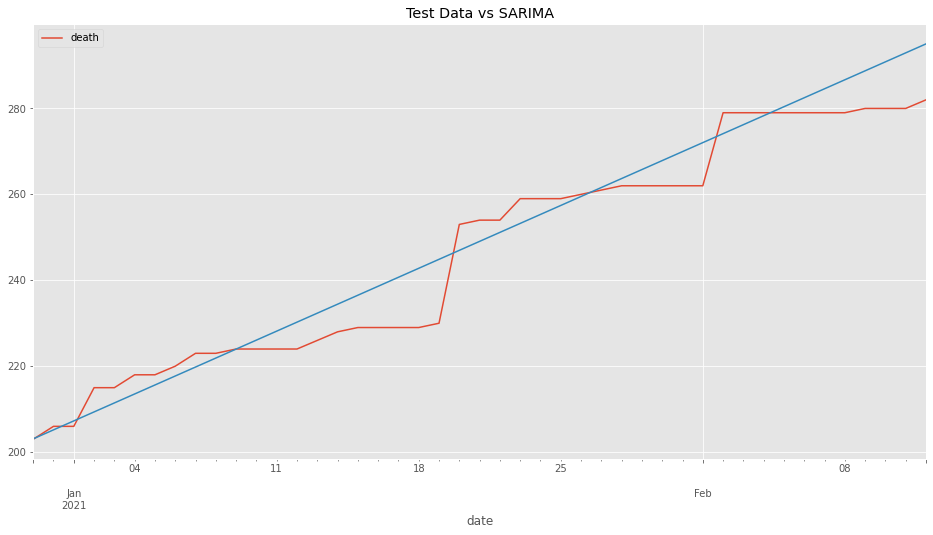

In [297]:
pd.DataFrame(test_data['death']).plot(figsize=(16,8),legend=True,title='Test Data vs SARIMA',grid=True)
plt.plot(pd.DataFrame(predictions_AK))
plt.show()

In [298]:
model = sm.tsa.statespace.SARIMAX(df_alaska['death'], order=stepwise_fit.order)
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  344
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -771.585
Date:                Tue, 16 Feb 2021   AIC                           1547.170
Time:                        08:25:04   BIC                           1554.840
Sample:                    03-06-2020   HQIC                          1550.225
                         - 02-12-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9661      0.010    -94.202      0.000      -0.986      -0.946
sigma2         5.2930      0.095     55.531      0.000       5.106       5.480
Ljung-Box (L1) (Q):                   0.07   Jarque-

In [299]:
fcast = res.predict(start=len(df_AK),end=len(df_AK)+45, typ='endogenous').rename('SARIMAX FORECAST')

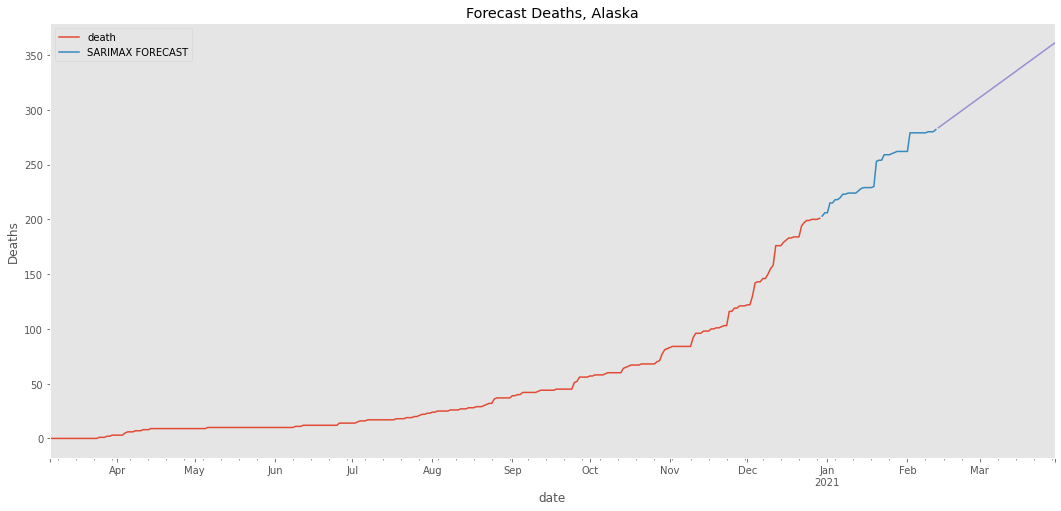

In [300]:
fig, ax = plt.subplots()

train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',title='Forecast Deaths, Alaska',grid=True);
test_data['death'].plot(grid=True);
fcast.plot(legend=True,figsize=(18,8)); 
ax.grid();
plt.show();

#### Below graph will show prediction data against test data as well as a separate future forecast.

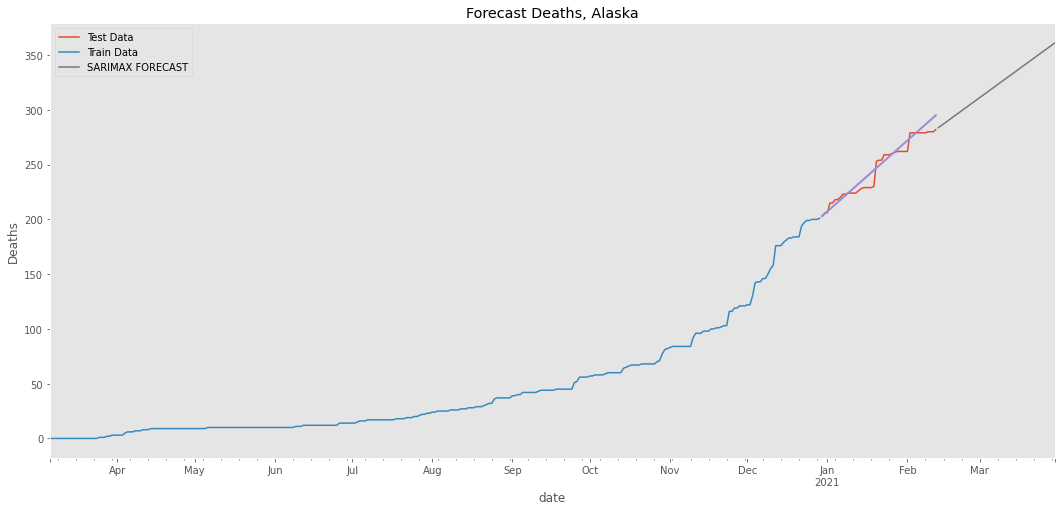

In [301]:
fig, ax = plt.subplots()

test_data['death'].plot(figsize=(16,8),legend=True,title='Forecast Deaths, Alaska',grid=True, label='Test Data');
train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',grid=True, label='Train Data');
plt.plot(predictions_AK, linewidth=2); # 'PREDICTIONS' FROM END OF TRAINING DATA
fcast.plot(legend=True,figsize=(18,8)); # SARIMA FORECAST
ax.grid();
plt.show();

#### Using Auto Arima to determine order and seasonal order for the SARIMA model is pretty effective here and provides a valid forecast. Given this run through the process, future forecasts will forecast an exogenous variable and plug that forecast back into the model. 

## SARIMAX Modeling

### New York State Ventilator Usage Forecast

#### SARIMAX modeling steps, annotated only for New York forecast
##### * create state specific dataframe
##### * obtain seasonality periods with seasonal decomp
##### * some states provide ventilator data, some provide icu, and others only hospitalization figures. when choosing an exogenous variable to forecast to supplement the death forecast, ventilator data should be prioritized, followed by icu and then hospitalization figures if nothing else is available. 
##### * gridsearch optimization using auto arima. auto arima function is built into custom library and is called by arima_tune() function
##### * evaluate_predictions(), evaluates the predictions against the test data. 
##### * build_SARIMAX_forecast() graphs and returns the first forward looking forecast with the target variable to forecast being the exogenous data we wish to use to enhance the final model. 
##### * get_exogenous_forecast_dataframe() builds and returns a workable dataframe with that forward looking forecast for input into final step
##### * build_SARIMAX_forecast() one more time, specifying the target (death) and the exogenous columns (onVentilatorCurrently)

#### NY State was one of the first states to experience the worst of the pandemic. In addition to this, they are one of the most populous states in the country, and have had a spike in Covid cases post-holiday season 2020. California just passed barely passed New York state in total deaths *related (not directly caused) by COVID-19, making New York the state with the second most deaths in the United States.  

In [425]:
# change to True, run cell to follow link
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open("https://deadline.com/2021/02/california-south-african-covid-19-variant-found-gavin-newsom-1234691514/")
    webbrowser.open("https://www.cityandstateny.com/articles/politics/new-york-state/new-coronavirus-numbers.html")
    webbrowser.open("http://www.op.nysed.gov/COVID-19_EO.html#") # new york state has issued executive orders to increase
    # the number of healtchare workers

In [426]:
df = state_dataframe(df_states, 'NY')

Successfully returned indexed dataframe for NY


In [427]:
df_ref = state_dataframe(df_states, 'NY')

Successfully returned indexed dataframe for NY


In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 2020-03-02 to 2021-02-12
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  348 non-null    object 
 1   death                  348 non-null    float64
 2   inIcuCurrently         348 non-null    float64
 3   onVentilatorCurrently  348 non-null    float64
 4   positive               348 non-null    float64
 5   hospitalizedCurrently  348 non-null    float64
 6   deathIncrease          348 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 21.8+ KB


In [429]:
# death increase seasonal decomp plot shows that we have near weekly seasonality. 

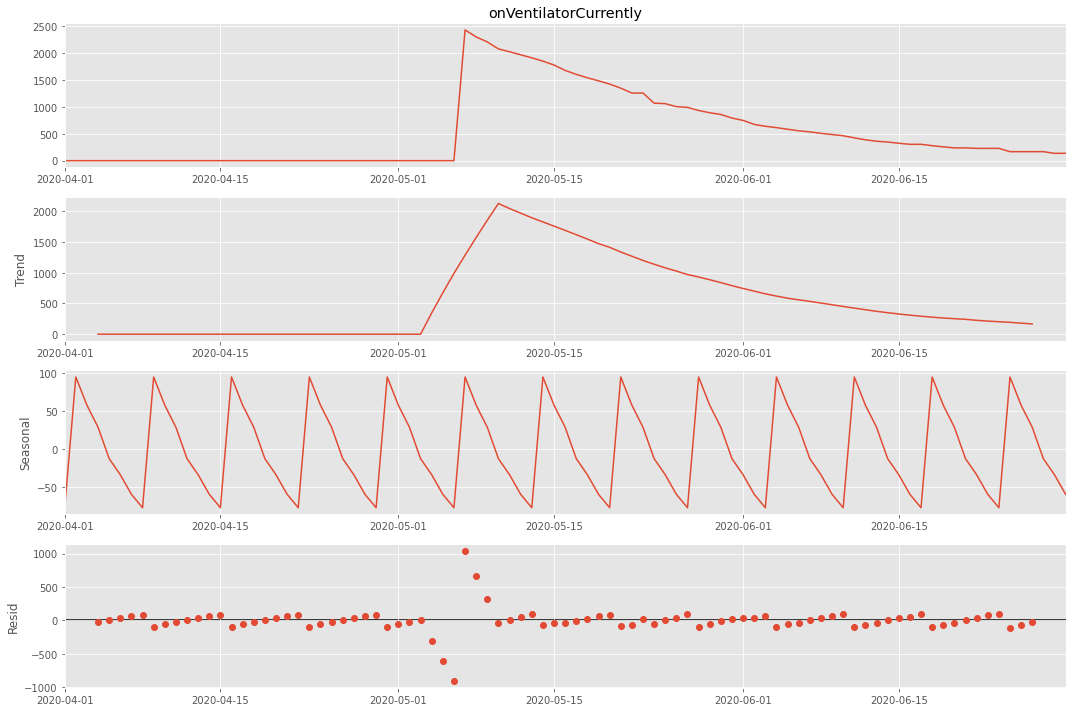

In [430]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['onVentilatorCurrently']).plot();
# m_periods = 7, or 7 days in each cycle since our frequency for the 
# time series index is 'D', or one day. 

In [431]:
# seasonality peaks match the peaks of the deathIncrease seasonal decomp.

ARIMA order is:  (0, 2, 2)
Seasonal ARIMA order is:  (0, 0, 1, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               onVentilatorCurrently   No. Observations:                  240
Model:             SARIMAX(0, 2, 2)x(0, 0, [1], 7)   Log Likelihood                -881.528
Date:                             Tue, 16 Feb 2021   AIC                           1771.057
Time:                                     13:28:33   BIC                           1784.774
Sample:                                 05-19-2020   HQIC                          1776.591
                                      - 01-13-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9036      0.051    -17.733      0.000      -1.003      -0.804
ma.L2          0.0592      0.051      1.167      0.243      -0.040       0.159
ma.S.L7        0.3439      0.057      6.011      0.000       0.232       0.456
sigma2       133.0677      7.314     18.195      0.000     118.733     147.402
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               204.70
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

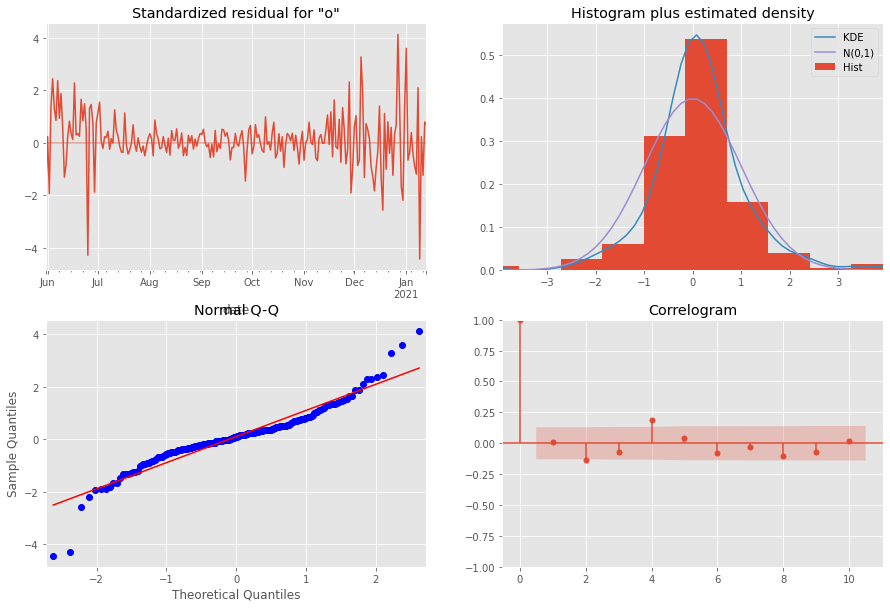

In [432]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'onVentilatorCurrently', 
                                                                days_to_forecast=30, m_periods=7, 
                                                                verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details
# forecasting 30 days out into the future with a seasonality length of 7 days
# verbose = true returns orders and summary as well as plotting diagnostics

#### Reasonable q-q plot. Model summary is good overall. 

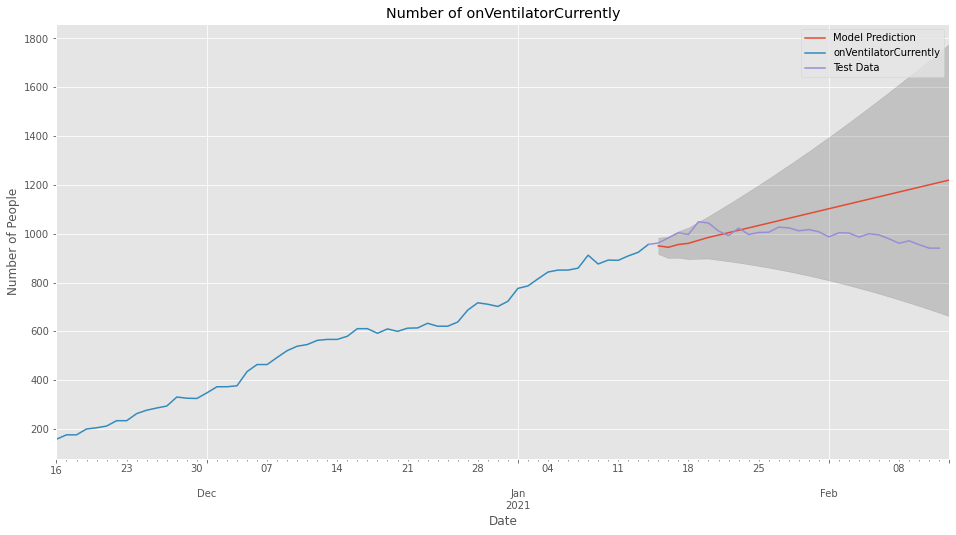

In [433]:
evaluate_predictions(results, df, 'onVentilatorCurrently', stepwise_fit=stepwise_fit, 
                     alpha=.05, days_to_forecast=30)
# plot training time and test time
# this evaluates the model using a train test split while also providing
# a forecast of confidence intervals with an alpha of .05. 

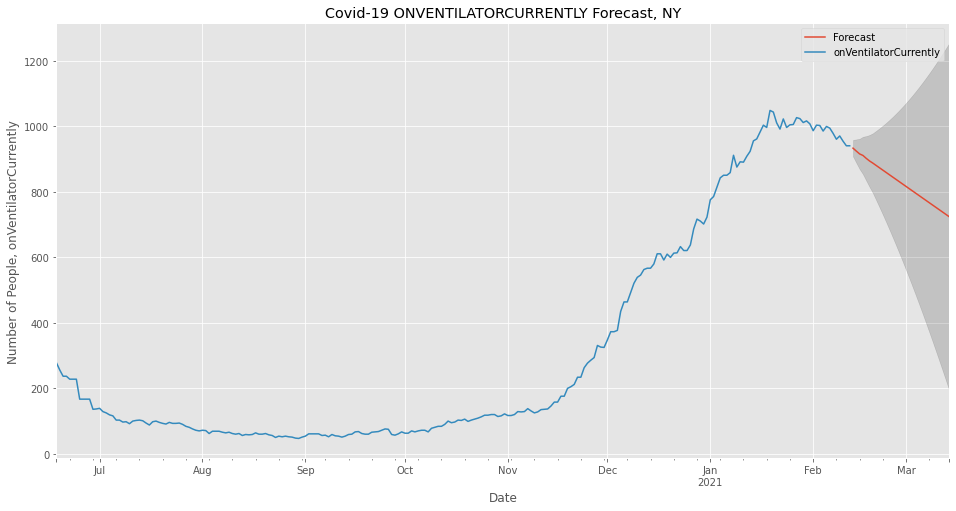

In [434]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='onVentilatorCurrently', 
                                                     days_to_forecast=30, 
                                                     stepwise_fit=stepwise_full, 
                                                     alpha=.05, state_postal_code='NY')

# this is a forecast of those people who are currently on ventilators in cases
# involving Covid-19. This forecast data will be used to enhance the overall 
# forecast of death or deathIncrease (rate of death)

In [435]:
forecast_obj.conf_int()[-3:]

,lower onVentilatorCurrently,upper onVentilatorCurrently
2021-03-12,254.437515,1222.552583
2021-03-13,224.304039,1238.460202
2021-03-14,193.822435,1254.715949


#### New York ventilator data has shown an improvement more recently. The recent downward trend here is encouraging, and it is likely to continue.
#### The initial spike in ventilator usage in New York (seen below) was likely a result of not knowing how to properly treat the virus. As time has progressed we have learned that ventilators should only be used in the most severe cases. Additional methods like keeping Covid patients on their stomachs while using the ventilator has been claimed to be more effective. 
#### Finally, this forecast will be used to influence a forecast of deaths in New York.

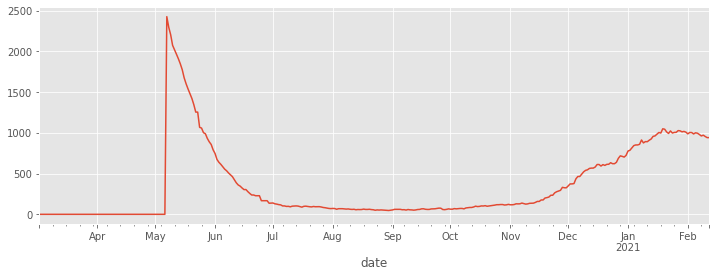

In [436]:
df['onVentilatorCurrently'].plot(figsize=(12,4)); # see spike here coming down 
# from initial May 2020 reporting. 

### New York State Deaths Forecast 
#### Modeled using New York's Ventilator Usage Forecast

In [437]:
# returns df_forecast for input into the final build sarimax forecast below
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='onVentilatorCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=7)

In [438]:
df_forecast.tail(5)

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
2021-03-10,NaN,NaN,NaN,752.720906,NaN,NaN,NaN
2021-03-11,NaN,NaN,NaN,745.607978,NaN,NaN,NaN
2021-03-12,NaN,NaN,NaN,738.495049,NaN,NaN,NaN
2021-03-13,NaN,NaN,NaN,731.382121,NaN,NaN,NaN
2021-03-14,NaN,NaN,NaN,724.269192,NaN,NaN,NaN


In [439]:
# create final model using sarimax
full_exog_model = SARIMAX(df['death'],df['onVentilatorCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

# fit model before plugging into below function
model = full_exog_model.fit()

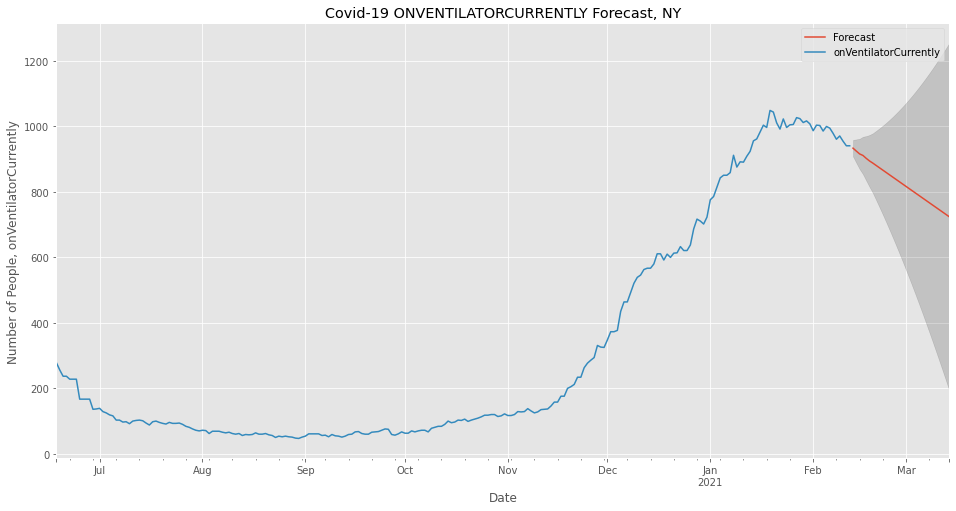

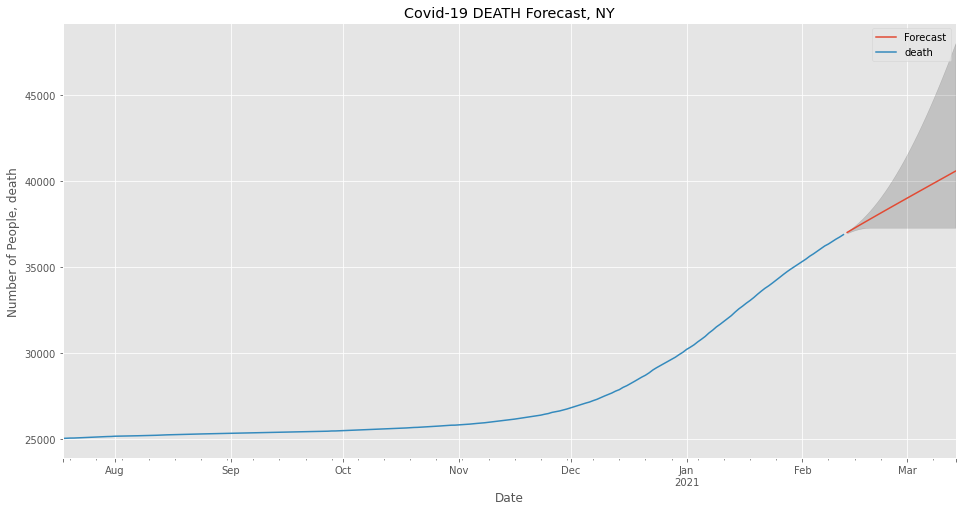

In [440]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='onVentilatorCurrently', 
                                                     days_to_forecast=30, 
                                                     stepwise_fit=stepwise_full, 
                                                     alpha=.05, state_postal_code='NY')

# returns df_forecast for input into the final build sarimax forecast below
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='onVentilatorCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=7)

# create final model using sarimax
full_exog_model = SARIMAX(df['death'],df['onVentilatorCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

# fit model before plugging into below function
model = full_exog_model.fit()

exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='onVentilatorCurrently',
                                                         state_postal_code='NY')

In [397]:
# actual numbers of 95% confidence interval. alpha defaults to .05
results_forecast.conf_int()[-3:]

,lower death,upper death
2021-03-12,33784.347268,46876.594343
2021-03-13,33462.303924,47440.180518
2021-03-14,33128.260645,48015.668384


##### Above graph implements usage of a function that flattens the lower portion of the confidence interval instead of allowing it to decrease. Deaths remain flat in a best case scenario instead of 'decreasing' in the forecast. 

### New York Analysis and Recommendations

#### New York flattened its curve from the beginning of the pandemic until the Thanksgiving holidays when everything suddenly became more difficult. There is a clear increase in deaths beginning around mid November and into Christmas and the New Year, likely a result of family gatherings, social gatherings, and increased survivability in the cold. 
#### There is every possibility that without continuing social distancing and enforcing the wearing of masks that the rate of death will once again increase.

##### Recommendations for the state include the following:
##### *Lower the number of people allowed at indoor private gatherings from the current amount of 10. Social gatherings are not economically essential. Certain states have limits of one or two households per private residence which has proven to limit the spread of the disease. 
##### * Increase effort to improve awareness. Covering the mouth but not the nose does not limit the spread of Covid-19. Mandate signage depicting proper mask usage at public establishments. 
##### * Continue social distancing policies and reduce the number of outdoor events. The pandemic in New York is not under control. 

### California Deaths Forecast
#### Modeled using ICU Forecast (ICU Forecast not shown)

In [326]:
# change to True, run cell to follow link
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open("https://deadline.com/2021/02/california-south-african-covid-19-variant-found-gavin-newsom-1234691514/")
    webbrowser.open("https://covid19.ca.gov/?utm_source=google&utm_medium=cpc&utm_campaign=ca-covid19response-august2020&utm_term=covid%2019&gclid=CjwKCAiAjp6BBhAIEiwAkO9WukC-31gfIfspHCyf7FgUt_vAh4OrFSPfX0QXfbyLfQRvVDnlIJPhKxoCZqQQAvD_BwE")
    

In [327]:
df_ref = state_dataframe(df_states, 'CA')

Successfully returned indexed dataframe for CA


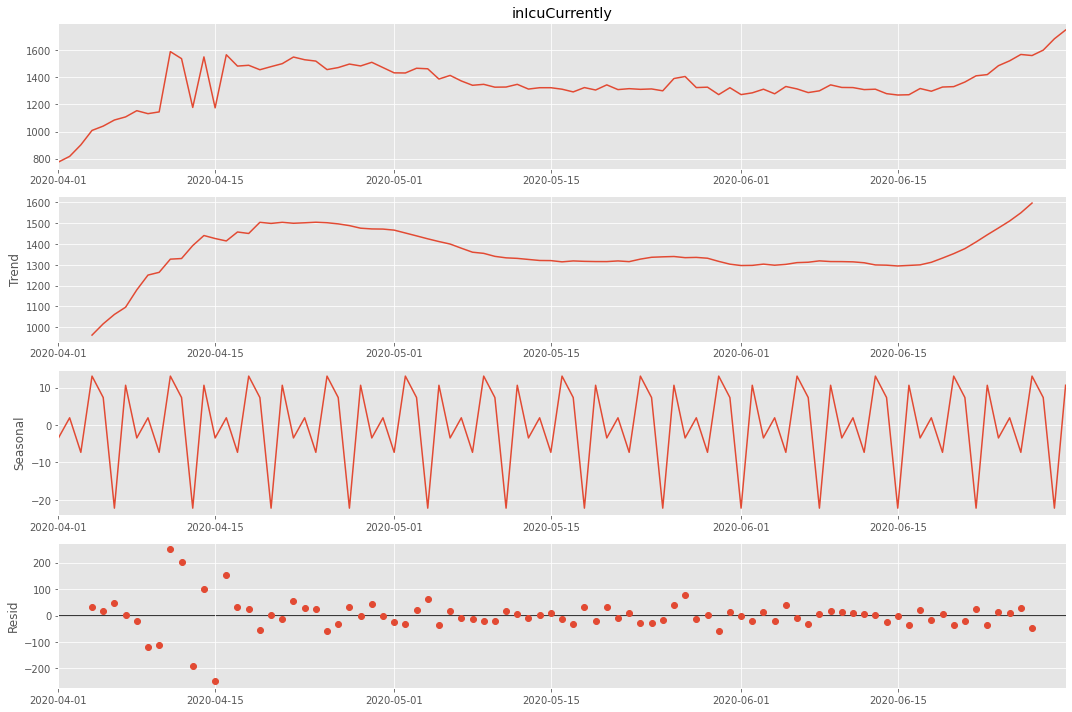

In [328]:
plt.rcParams['figure.figsize']=(15,10);
sd(df_ref.loc['04-2020':'06-2020']['inIcuCurrently']).plot();

ARIMA order is:  (1, 2, 3)
Seasonal ARIMA order is:  (2, 0, 1, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      inIcuCurrently   No. Observations:                  240
Model:             SARIMAX(1, 2, 3)x(2, 0, [1], 7)   Log Likelihood               -1106.950
Date:                             Tue, 16 Feb 2021   AIC                           2229.900
Time:                                     08:28:19   BIC                           2257.157
Sample:                                 05-19-2020   HQIC                          2240.904
                                      - 01-13-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9631      0.049    -19.747      0.000      -1.059      -0.868
ma.L1         -0.0191      0.089     -0.214      0.830      -0.194       0.156
ma.L2         -0.7361      0.078     -9.422      0.000      -0.889      -0.583
ma.L3          0.1093      0.075      1.465      0.143      -0.037       0.256
ar.S.L7        0.2439      0.325      0.750      0.453      -0.393       0.881
ar.S.L14       0.1039      0.071      1.465      0.143      -0.035       0.243
ma.S.L7       -0.2487      0.336     -0.740      0.460      -0.908       0.410
sigma2      1191.5610    102.142     11.666      0.000     991.366    1391.756
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                23.81
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.62
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

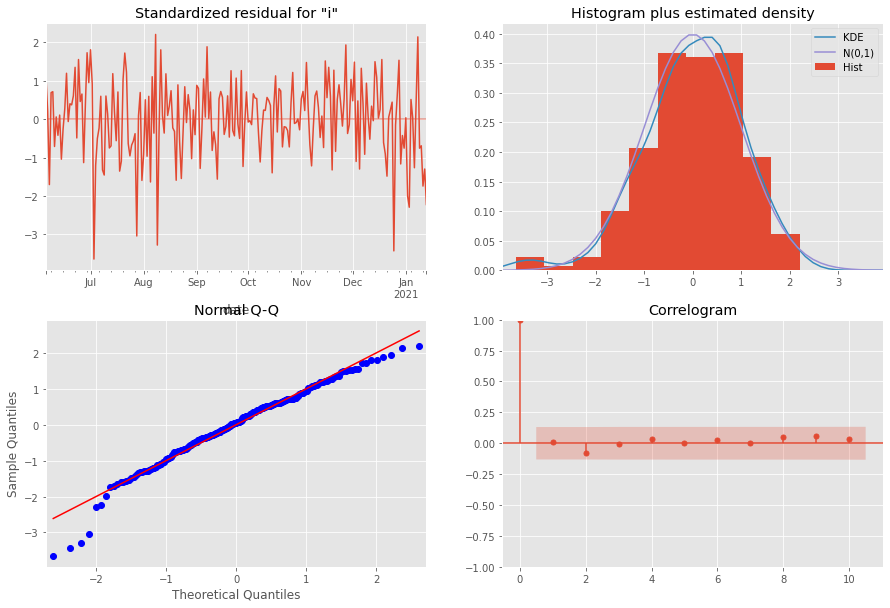

In [329]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df_ref, 'inIcuCurrently', 
                                                                days_to_forecast=30, m_periods=7, 
                                                                verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details
# forecasting 30 days out into the future with a seasonality length of 7 days

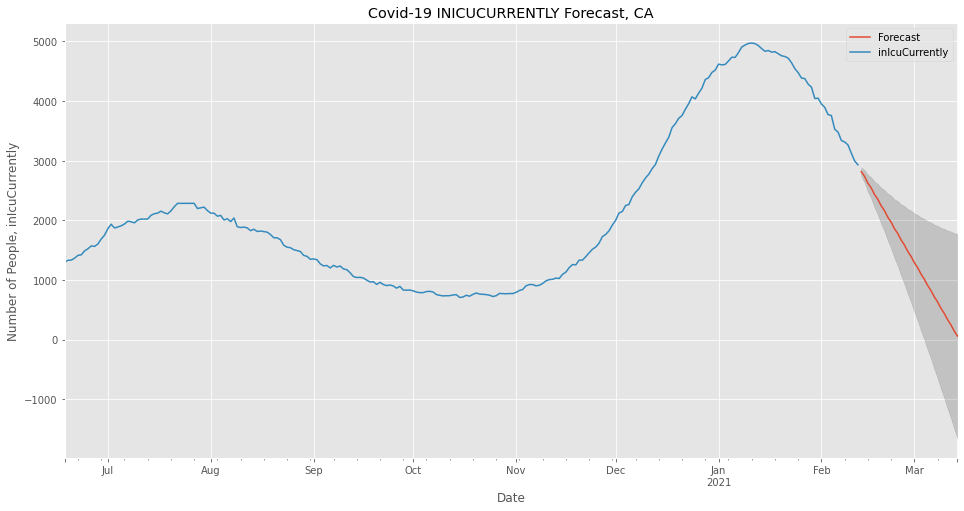

In [330]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df_ref, 
                                                     target_column= 'inIcuCurrently', 
                                                     days_to_forecast=30, 
                                                     stepwise_fit=stepwise_full, 
                                                     alpha=.05, state_postal_code='CA')

# this is a forecast of those people who are currently on ventilators in cases
# involving Covid-19. This forecast data will be used to enhance the overall 
# forecast of death or deathIncrease (rate of death)

In [331]:
forecast_obj.conf_int()[-3:]

,lower inIcuCurrently,upper inIcuCurrently
2021-03-12,-1316.197735,1812.058878
2021-03-13,-1493.942065,1783.965606
2021-03-14,-1657.600905,1770.970581


Successfully returned indexed dataframe for CA
ARIMA order is:  (1, 2, 3)
Seasonal ARIMA order is:  (2, 0, 1, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      inIcuCurrently   No. Observations:                  240
Model:             SARIMAX(1, 2, 3)x(2, 0, [1], 7)   Log Likelihood               -1106.950
Date:                             Tue, 16 Feb 2021   AIC                           2229.900
Time:                                     08:29:05   BIC                           2257.157
Sample:                                 05-19-2020   HQIC                          2240.904
                                      - 01-13-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9631      0.049    -19.747      0.000      -1.059      -0.868
ma.L1         -0.0191      0.089     -0.214      0.830      -0.194       0.156
ma.L2         -0.7361      0.078     -9.422      0.000      -0.889      -0.583
ma.L3          0.1093      0.075      1.465      0.143      -0.037       0.256
ar.S.L7        0.2439      0.325      0.750      0.453      -0.393       0.881
ar.S.L14       0.1039      0.071      1.465      0.143      -0.035       0.243
ma.S.L7       -0.2487      0.336     -0.740      0.460      -0.908       0.410
sigma2      1191.5610    102.142     11.666      0.000     991.366    1391.756
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                23.81
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.62
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

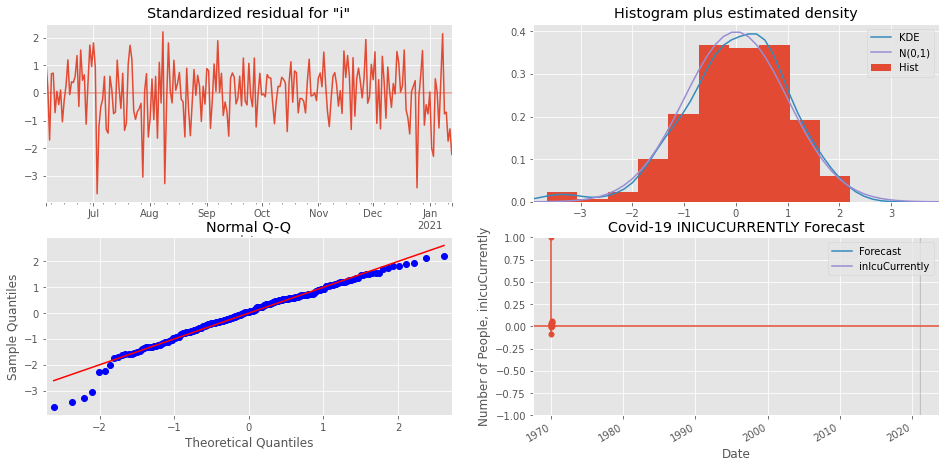

In [332]:
state_dataframe, exog_forecast = create_exog_forecast(df_states, 'inIcuCurrently', 
                                                      m_periods=7, state_postal_code='CA')

In [333]:
# normal q-q plot

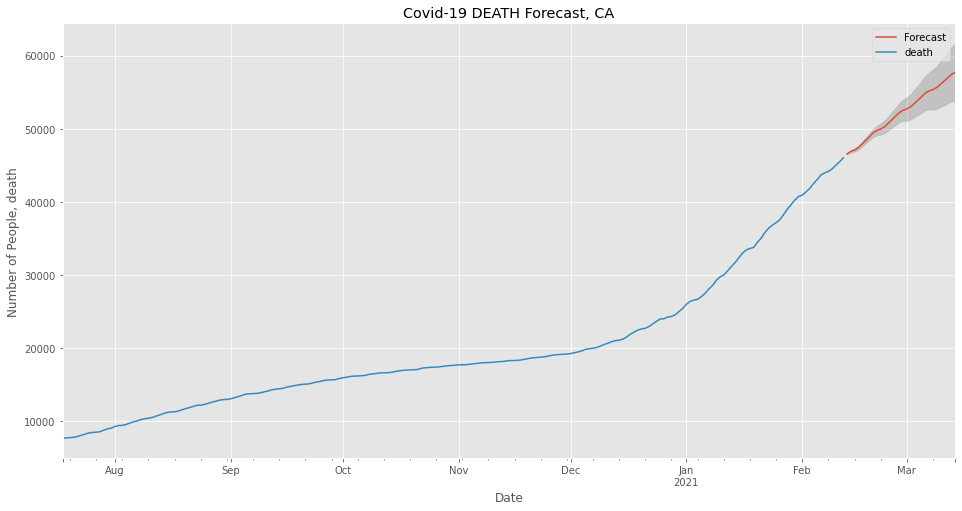

In [334]:
forecast_object = graph_exog_forecast(dataframe=state_dataframe, 
                                      target_column='death', 
                                      exogenous_column='inIcuCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=30, 
                                      train_days=270, m_periods=7,
                                      state_postal_code='CA')

In [335]:
forecast_object.predicted_mean[-5:] # projected mean deaths
# by March 14th, 2021 stand at 57,730.  

2021-03-10    56063.879182
2021-03-11    56515.194316
2021-03-12    56978.468058
2021-03-13    57444.262203
2021-03-14    57729.645022
Freq: D, Name: predicted_mean, dtype: float64

In [336]:
forecast_object.conf_int()[-5:] # upper confidence interval of 95% forecasts
# deaths of over 61,000 by March 14th, 2021. 

,lower death,upper death
2021-03-10,52931.486803,59196.271562
2021-03-11,53183.717245,59846.671386
2021-03-12,53443.382517,60513.553599
2021-03-13,53689.901401,61198.623006
2021-03-14,53749.443886,61709.846157


### California Analysis and Recommendations

#### California has experienced an even more drastic increase in deaths since the holidays than any other state. What is happening is an emergency with over 540 Covid deaths on Feb. 11th, 2021 alone. The California state website talks about helping to slow the spread of Covid. Given the circumstances, this language is not urgently and clearly conveying the message that the situation needs immediate attention from each and every individual living in the state. 

##### Recommendations for the state include the following:
##### * Require wearing a mask if an individual is not in or on their private property. Allow no exceptions. 
##### * Prohibit private and public gatherings of 5 or more people unless from the same household. 
##### * The spread of this disease in this state will continue to take lives if people are not made to understand the consequences of selfish behavior. Introduce visual evidence of the rammifications of the virus with an emphasis on personal stories on public social media and television. 

### Texas Hospitalized Forecast

In [398]:
# change to True, run cell to follow link(s)
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open("https://www.kvue.com/article/news/health/coronavirus/austin-texas-stage-4-covid-coronavirus-stage-5-feb-9/269-07d19225-d943-496a-8246-8940489fbc65")
    webbrowser.open("https://www.khou.com/article/news/local/texas/texas-covid-hospitalizations-record-houston-harris-county/285-2549ca26-ebf6-40e0-b29e-e4c945e08a50")
    webbrowser.open("https://apps.texastribune.org/features/2020/texas-coronavirus-cases-map/?_ga=2.53372705.880277519.1613246925-1270976238.1613246925")
    

#### Texas is also a populous state and has been inclined to open back up quickly to keep the economy going. The state has not reported ICU or Ventilator numbers to the Covid Tracking Project. A KHOU article cites a decrease in hospitalizations while warning about the continued threat of breaching hospital capacity. 

In [414]:
df = state_dataframe(df_states, 'TX')

Successfully returned indexed dataframe for TX


In [400]:
df_ref = state_dataframe(df_states, 'TX')

Successfully returned indexed dataframe for TX


In [401]:
df.tail()

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2021-02-08,TX,38700.0,2667.0,0.0,2491227.0,9401.0,57
2021-02-09,TX,39001.0,2777.0,0.0,2504556.0,9401.0,301
2021-02-10,TX,39386.0,2740.0,0.0,2517453.0,9165.0,385
2021-02-11,TX,39771.0,2703.0,0.0,2529343.0,8933.0,385
2021-02-12,TX,40095.0,2582.0,0.0,2541845.0,8607.0,324


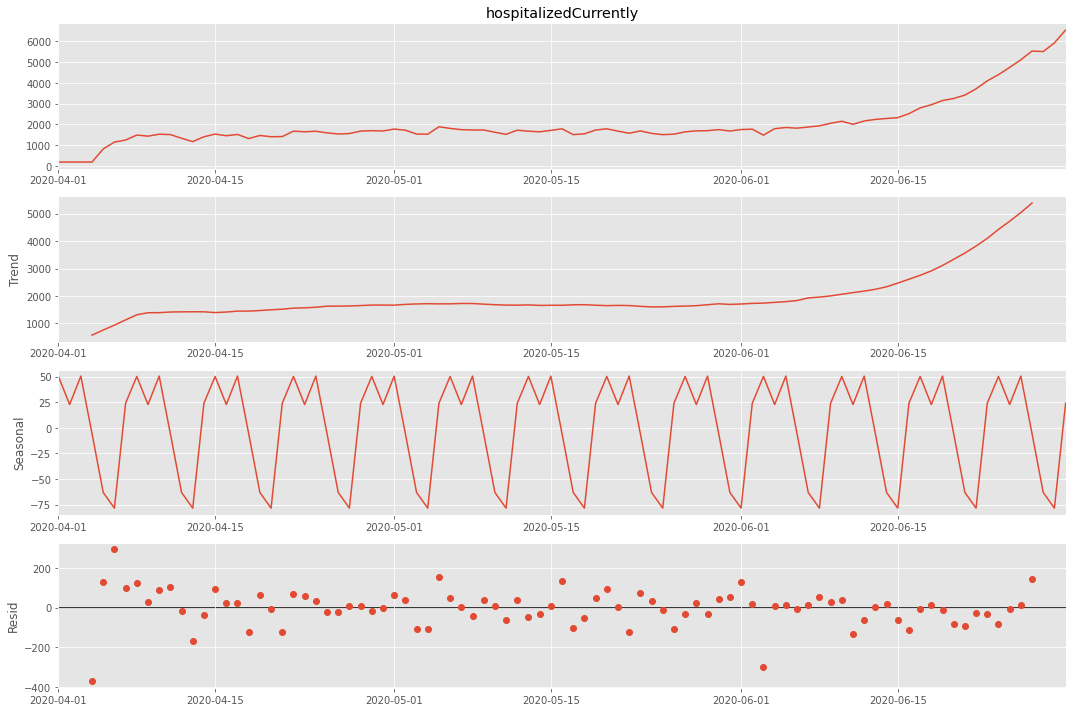

In [402]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['hospitalizedCurrently']).plot();

ARIMA order is:  (0, 2, 1)
Seasonal ARIMA order is:  (0, 0, 0, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     hospitalizedCurrently   No. Observations:                  240
Model:                  SARIMAX(0, 2, 1)   Log Likelihood               -1560.634
Date:                   Tue, 16 Feb 2021   AIC                           3125.269
Time:                           10:35:56   BIC                           3132.197
Sample:                       05-19-2020   HQIC                          3128.061
                            - 01-13-2021                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8240      0.031    -26.164      0.000      -0.886      -0.762
sigma2      3.242e+04   1014.928     31.942      0.000    3.04e+04    3.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2986.65
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -2.10
Prob(H) (two-sided):                  0.78   Kurtosis:                        19.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

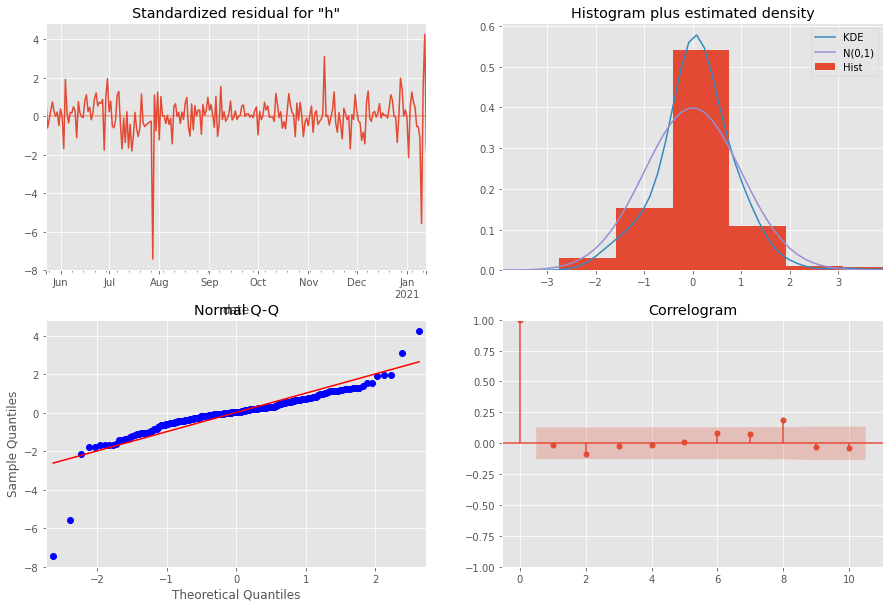

In [403]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'hospitalizedCurrently', 
                                                                days_to_forecast=30, m_periods=7, 
                                                                verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details

#### The ends of the q-q plot are not quite in line.

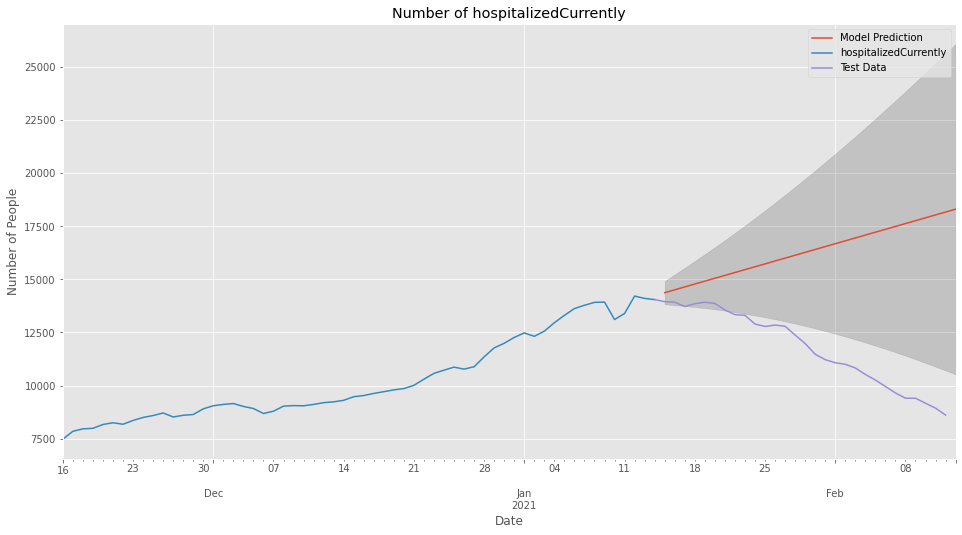

In [404]:
evaluate_predictions(results, df, 'hospitalizedCurrently', 
                     stepwise_fit=stepwise_fit, alpha=.05, days_to_forecast=30)
# plot training time and test time

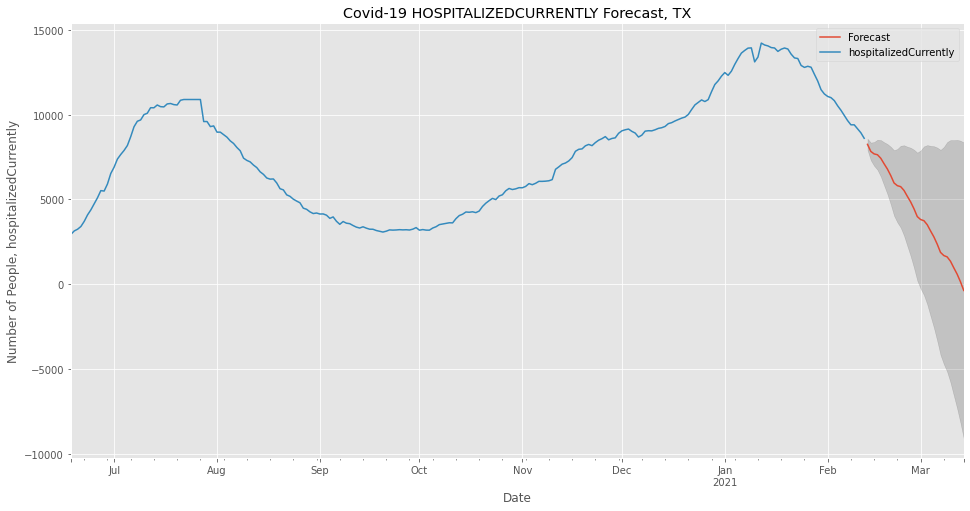

In [405]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='hospitalizedCurrently', 
                                                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                                                     alpha=.05,
                                                     state_postal_code='TX')

In [406]:
# graph of those currently hospitalized and subsequent forecast above shows
# a declining rate of hospitalization with a chance to remain flat. 

### Texas Deaths Forecast
#### Modeled using Texas's Hospitalized Forecast

In [407]:
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='hospitalizedCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=7)

In [408]:
# get exogenous forecast dataframe will return an extended dataframe
# containing the forecasted exogenous column from build_SARIMAX_forecast
# above after taking in the variable exog_forecast

In [409]:
full_exog_model = SARIMAX(df['death'],df['hospitalizedCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

In [410]:
# fit model 
model = full_exog_model.fit()

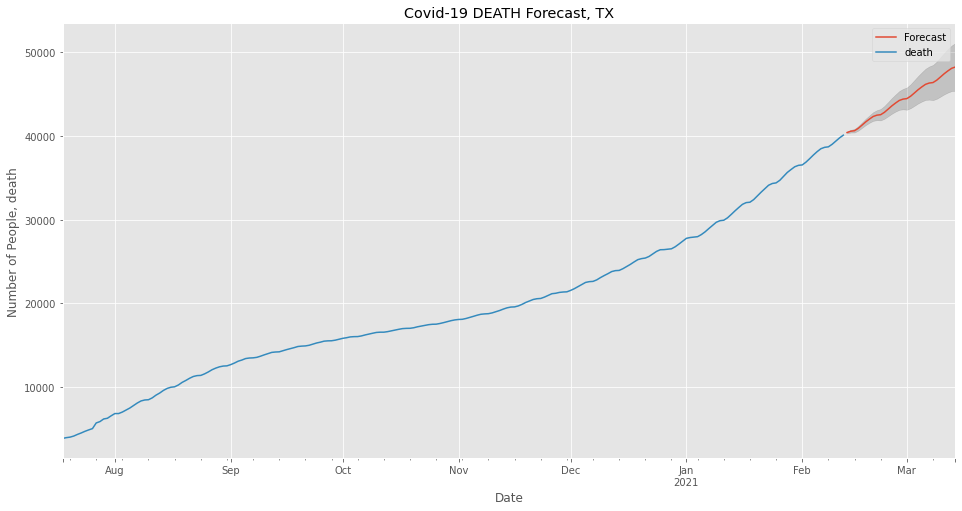

In [411]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='hospitalizedCurrently',
                                                         state_postal_code='TX')

In [412]:
results_forecast.conf_int()[-5:]

,lower death,upper death
2021-03-10,44698.502289,49384.094774
2021-03-11,44967.253255,49898.574043
2021-03-12,45185.608779,50364.084997
2021-03-13,45360.771459,50804.571114
2021-03-14,45382.988130,51095.233892


### Texas Analysis and Recommendations

#### The number of people currently hospitalized has decreased in recent weeks and I am forecasting that to continue. However, deaths are forecasted to slow only slightly over the next 30 days. There is some improvement, but it isn't enough.

##### Recommendations for the state include the following:
##### * Limit private social gatherings. 
##### * There are those in Texas who believe that the virus is a joke, that the rules don't apply to them, and that there are no consequences. Like California, an awareness campaign with personal stories and visual evidence of what Covid does could help contain the virus. 
##### * Make wearing a mask outside of one's private property required. 

### Florida Deaths Forecast
#### Modeled using Hospitalized Currently Forecast

In [354]:
# change to True, run cell to follow link
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open("https://www.newsweek.com/covid-florida-travel-advice-state-new-uk-variant-cases-1568572")

#### Florida currently has 300 new cases of the UK variant of Covid with 0 travel restrictions in place. The spread of the virus within Florida and throughout the rest of the United States as a result of a lack of travel bans and restraint is a serious issue. This section will forecast rate of death, total deaths, and will use the number of people currently hospitalized as an exogeous forecast. (data as of 2-10-2021)

In [355]:
df_ref = state_dataframe(df_states, 'FL')

Successfully returned indexed dataframe for FL


In [356]:
df_ref.tail()

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2021-02-08,FL,28287.0,0.0,0.0,1751343.0,5381.0,126
2021-02-09,FL,28526.0,0.0,0.0,1758254.0,5307.0,239
2021-02-10,FL,28691.0,0.0,0.0,1765659.0,5129.0,165
2021-02-11,FL,28871.0,0.0,0.0,1774013.0,4906.0,180
2021-02-12,FL,29061.0,0.0,0.0,1781450.0,4825.0,190


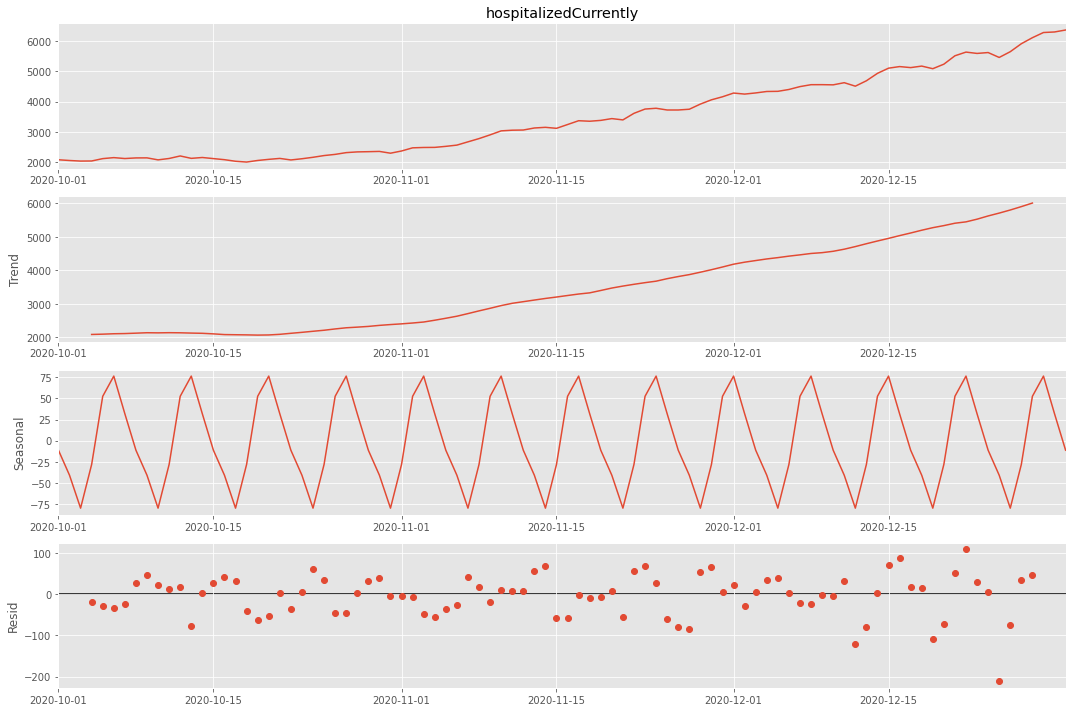

In [357]:
plt.rcParams['figure.figsize']=(15,10);
sd(df_ref.loc['10-2020':'12-2020']['hospitalizedCurrently']).plot(); # seasonality of about 6-7 days

Successfully returned indexed dataframe for FL
ARIMA order is:  (0, 1, 0)
Seasonal ARIMA order is:  (0, 0, 1, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               hospitalizedCurrently   No. Observations:                  225
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 6)   Log Likelihood               -1650.364
Date:                             Tue, 16 Feb 2021   AIC                           3304.729
Time:                                     08:34:47   BIC                           3311.489
Sample:                                 05-19-2020   HQIC                          3307.460
                                      - 12-29-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L6        0.1485      0.234      0.634      0.526      -0.311       0.608
sigma2      2.362e+05   2300.288    102.690      0.000    2.32e+05    2.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):            335172.89
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            13.52
Prob(H) (two-sided):                  0.00   Kurtosis:                       193.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

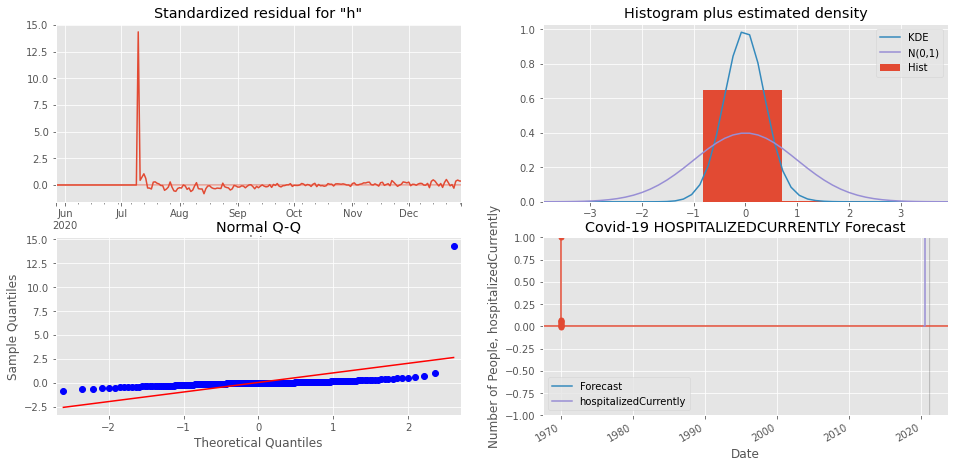

In [358]:
state_dataframe, exog_forecast = create_exog_forecast(df_states, 'hospitalizedCurrently', 
                                                      days_to_forecast=45, m_periods=7, 
                                                      state_postal_code='FL')

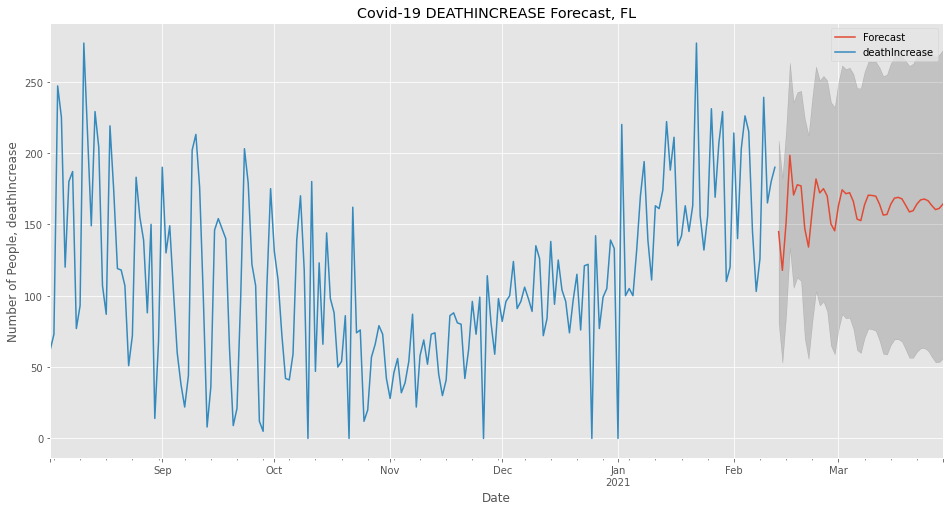

In [359]:
forecast_object = graph_exog_forecast(dataframe=state_dataframe, 
                                      target_column='deathIncrease', 
                                      exogenous_column='hospitalizedCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=45, 
                                      train_days=270, m_periods=7,
                                      state_postal_code='FL')

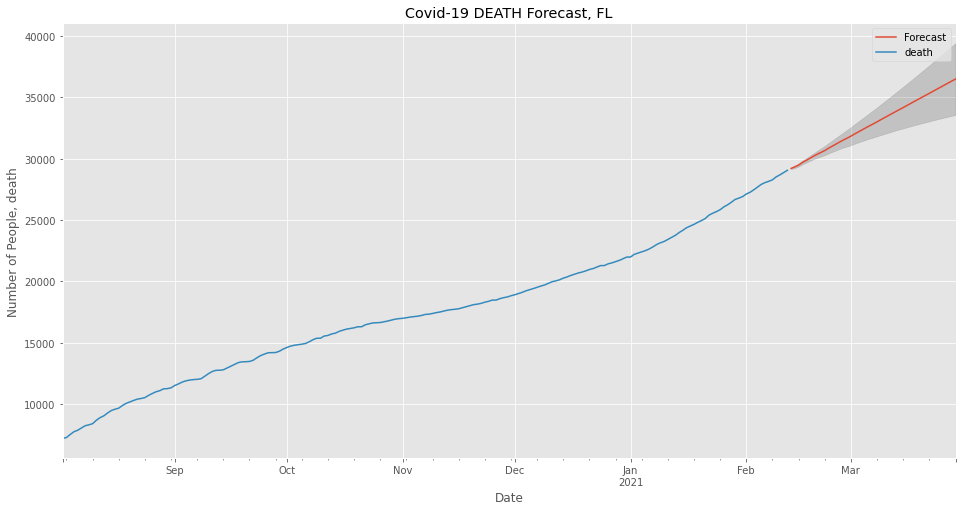

In [360]:
forecast_object = graph_exog_forecast(dataframe=state_dataframe, 
                                      target_column='death', 
                                      exogenous_column='hospitalizedCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=45, 
                                      train_days=270, m_periods=7,
                                      state_postal_code='FL')

In [361]:
forecast_object.predicted_mean[-5:] # projected mean deaths for
# by the end of March 

2021-03-25    35837.119536
2021-03-26    36003.597226
2021-03-27    36168.891724
2021-03-28    36333.435035
2021-03-29    36498.392480
Freq: D, Name: predicted_mean, dtype: float64

### Florida Analysis and Recommendations

#### Florida does not have any travel restrictions in place. There have been and will continue to be a steady rate of Covid deaths, likely reaching over 35000 by the end of March. 

##### Recommendations for the state include the following:
##### * Florida is fully opened - implement travel restrictions and reduce the number of people allowed to privately gather.
##### * Pre and post-Super Bowl footage showed business as usual with zero mask usage. Implement and enforce laws requiring masks in public. There are plenty of states that are responsibly open that are mitigating the spread of this virus. Florida seems to be encouraging the spread. 
##### * Common sense is easy. Don't breathe into peoples' faces, wear a mask, and keep your distance. 

### United States Death Forecast

In [362]:
# change to True, run cell to follow link(s)
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open("")

In [363]:
df_whole_US.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
date,,,,,,,,,,,,,,,,,,,,,
2021-02-12,56,27266230.0,122400369.0,9434.0,71504.0,839119.0,14775.0,43389.0,4849.0,4126.0,...,2021-02-12T24:00:00Z,NaN,0,0,5418,2345,567071,100570,1816007,c402515c19b77ba9243af172a9c5799f13cd8e56
2021-02-11,56,27165660.0,121833298.0,11981.0,74225.0,836774.0,15190.0,43291.0,4970.0,4113.0,...,2021-02-11T24:00:00Z,NaN,0,0,3873,2460,588596,102417,1872586,9e06c1c2bc7906114b2dfb77c02fac6a1ff15c7c
2021-02-10,56,27063243.0,121244702.0,12079.0,76979.0,834314.0,15788.0,43184.0,5121.0,4106.0,...,2021-02-10T24:00:00Z,NaN,0,0,3445,3226,385138,95194,1393156,a821a2f23aaee791d155df7e3a2755b31c1bdd32
2021-02-09,56,26968049.0,120859564.0,10516.0,79179.0,831088.0,16129.0,43000.0,5216.0,4092.0,...,2021-02-09T24:00:00Z,NaN,0,0,2795,3144,492086,92986,1502502,0ad7fb536eb23f95461201090c436ec7f76ac052
2021-02-08,56,26875063.0,120367478.0,12114.0,80055.0,827944.0,16174.0,42833.0,5260.0,4080.0,...,2021-02-08T24:00:00Z,NaN,0,0,1309,1638,454325,77737,1434298,7abf3026a5235e6761608e2971df85adb1c9bb18


In [364]:
columns =  ['death',
            'inIcuCurrently',
            'onVentilatorCurrently',
            'positive',
            'hospitalizedCurrently',
            'deathIncrease']
            # sort_and_clean_df(df_whole_US, columns)

In [365]:
df_whole_US = sort_and_clean_df(df_whole_US, columns)

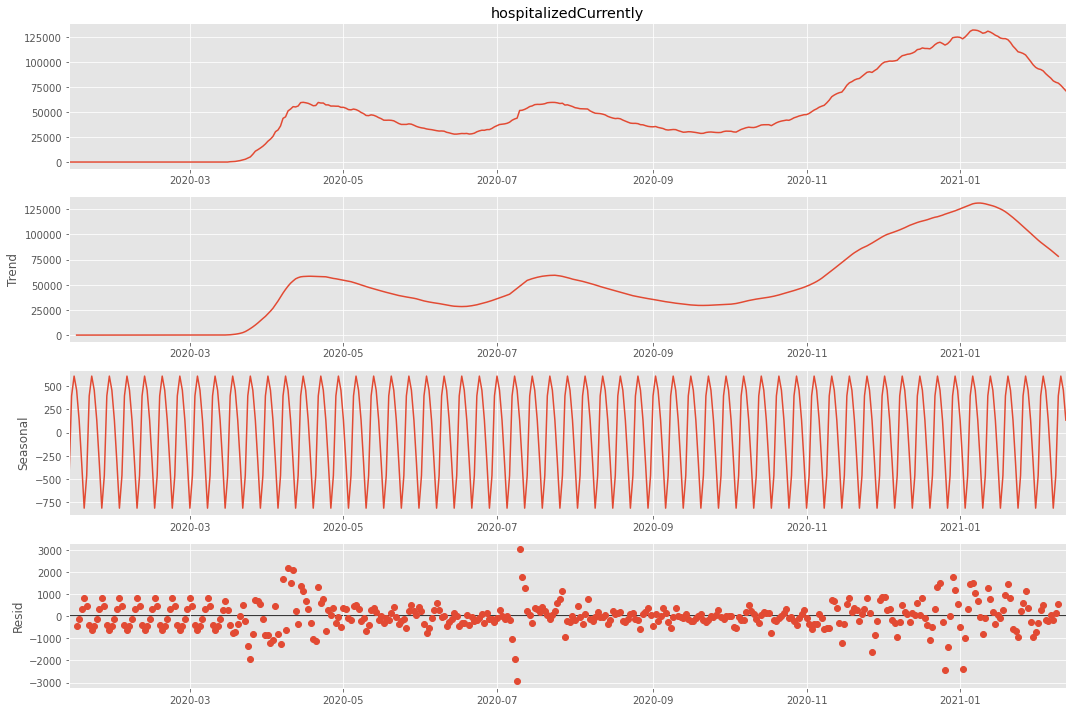

In [366]:
sd(df_whole_US['hospitalizedCurrently']).plot();

ARIMA order is:  (1, 2, 1)
Seasonal ARIMA order is:  (2, 0, 0, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:              hospitalizedCurrently   No. Observations:                  240
Model:             SARIMAX(1, 2, 1)x(2, 0, [], 7)   Log Likelihood               -1825.622
Date:                            Tue, 16 Feb 2021   AIC                           3661.243
Time:                                    08:35:43   BIC                           3678.279
Sample:                                05-19-2020   HQIC                          3668.121
                                     - 01-13-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1604      0.071      2.265      0.023       0.022       0.299
ma.L1         -0.8665      0.054    -16.195      0.000      -0.971      -0.762
ar.S.L7        0.3457      0.032     10.649      0.000       0.282       0.409
ar.S.L14       0.1347      0.054      2.509      0.012       0.029       0.240
sigma2      7.502e+05   2.72e+04     27.613      0.000    6.97e+05    8.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              3442.77
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             1.75
Prob(H) (two-sided):                  0.12   Kurtosis:                        21.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

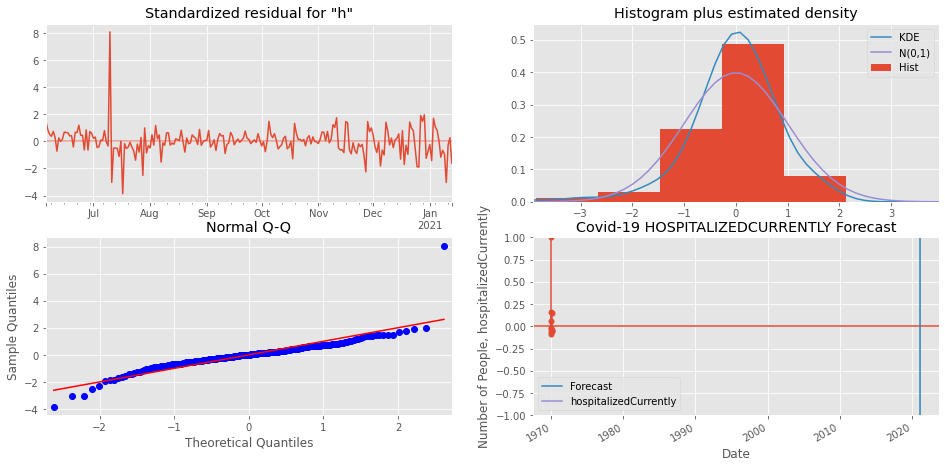

In [367]:
dataframe, exog_forecast = create_exog_forecast(df_whole_US, 'hospitalizedCurrently', 
                                                days_to_forecast=30, m_periods=7)

ARIMA order is:  (1, 2, 1)
Seasonal ARIMA order is:  (2, 0, 0, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:              hospitalizedCurrently   No. Observations:                  240
Model:             SARIMAX(1, 2, 1)x(2, 0, [], 7)   Log Likelihood               -1825.622
Date:                            Tue, 16 Feb 2021   AIC                           3661.243
Time:                                    08:36:07   BIC                           3678.279
Sample:                                05-19-2020   HQIC                          3668.121
                                     - 01-13-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1604      0.071      2.265      0.023       0.022       0.299
ma.L1         -0.8665      0.054    -16.195      0.000      -0.971      -0.762
ar.S.L7        0.3457      0.032     10.649      0.000       0.282       0.409
ar.S.L14       0.1347      0.054      2.509      0.012       0.029       0.240
sigma2      7.502e+05   2.72e+04     27.613      0.000    6.97e+05    8.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              3442.77
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             1.75
Prob(H) (two-sided):                  0.12   Kurtosis:                        21.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

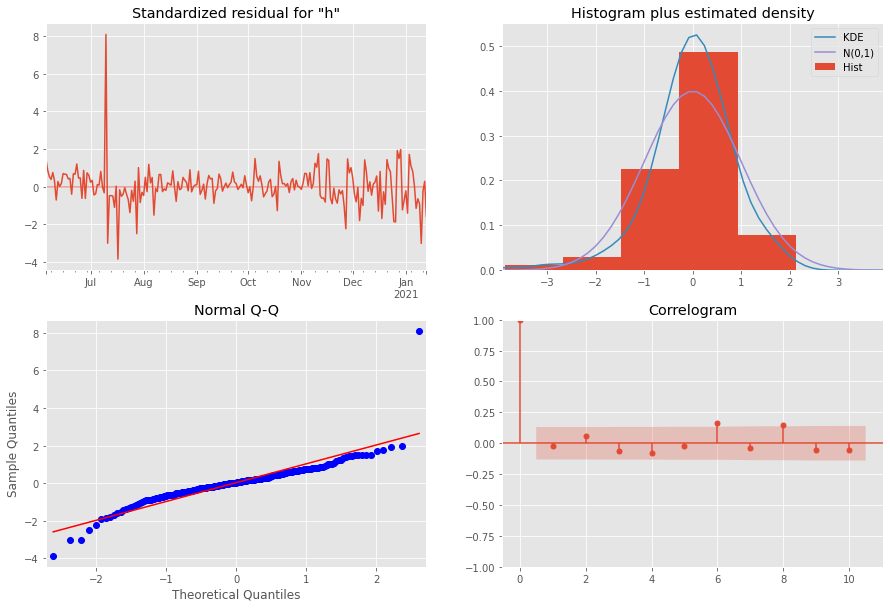

In [368]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df_whole_US, 'hospitalizedCurrently', 
                                                                days_to_forecast=30, m_periods=7, 
                                                                verbose=True) 

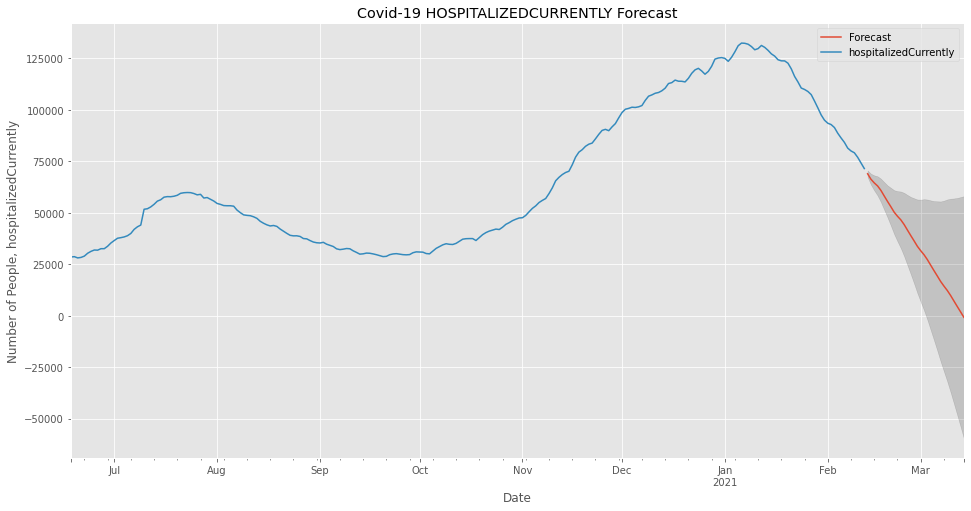

In [369]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=results_full, 
                     dataframe=df_whole_US, 
                     target_column='hospitalizedCurrently', 
                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                     alpha=.05)

In [370]:
results_forecast.conf_int()[-5:]

,lower hospitalizedCurrently,upper hospitalizedCurrently
2021-03-10,-37162.653996,56833.546329
2021-03-11,-42675.077866,56981.481885
2021-03-12,-48225.243116,57207.320274
2021-03-13,-53868.515937,57624.618009
2021-03-14,-59633.796094,58077.962479


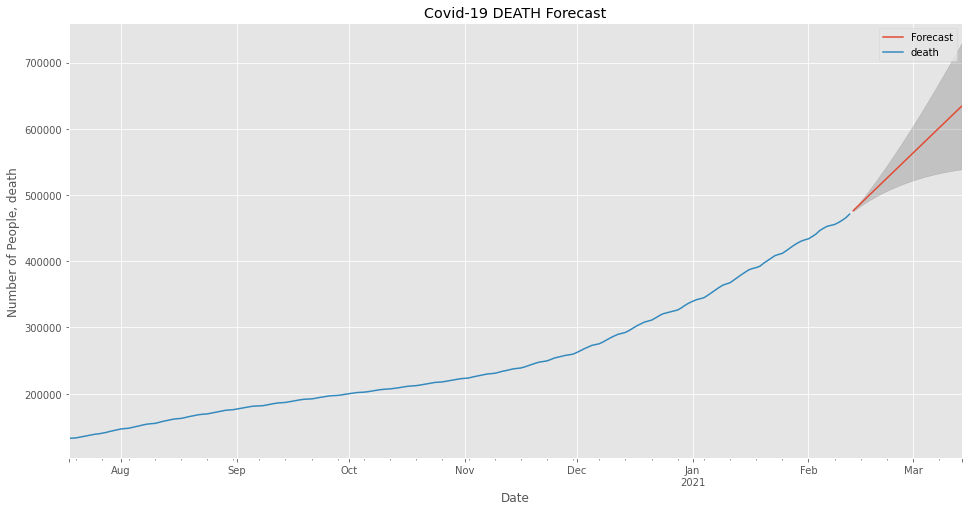

In [371]:
forecast_object_deaths = graph_exog_forecast(dataframe=dataframe, 
                                      target_column='death', 
                                      exogenous_column='hospitalizedCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=30, 
                                      train_days=270, m_periods=7)

In [372]:
forecast_object_deaths.conf_int(alpha=.05)[-5:]

,lower death,upper death
2021-03-10,535041.892460,689517.817213
2021-03-11,536047.723241,699351.622777
2021-03-12,536973.512268,709267.354209
2021-03-13,537822.057496,719264.943468
2021-03-14,538590.395094,729338.707643


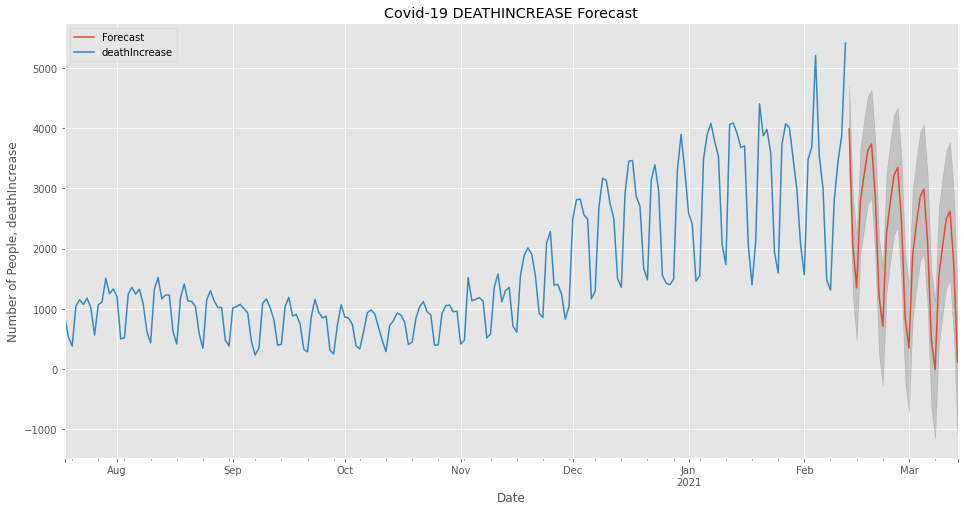

In [373]:
forecast_object = graph_exog_forecast(dataframe=dataframe, 
                                      target_column='deathIncrease', 
                                      exogenous_column='hospitalizedCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.025, days_to_forecast=30, 
                                      train_days=270, m_periods=7)

### United States Analysis and Recommendations

#### The holidays were literal killers. There is no getting around that fact, and without accelerated vaccinations we will continue to have increased deaths around future holidays. We have an opportunity to stop the spread of this virus with everyone's cooperation and resolve. My forecast for the country predicts there's a chance to truly slow and potentially stop the pandemic and Covid deaths by mid-March. There is also the possibility we continue to be irresponsible as a whole and deaths accelerate into the end of March.

##### I recommend that we come together as Americans in this one endeavor - to protect one another in what is a time of unmitigated risk. 
##### * WEAR A MASK
##### * STAY AWAY FROM PEOPLE YOU DONT LIVE WITH and respect their space. If you are someone who believes this is a hoax and you see someone with a mask on, just stay away from them. 
##### * Use the drive-thru whenever possible, have food delivered. Let's do our best to keep the food service industry going without sacrificing common sense. 
##### * Have your groceries delivered - grocery stores continue to stay extremely busy but there are services that are helping individuals pay their bills that can help limit the spread of this disease. 
##### * Limit your time indoors with friends and family not in your household and wear a mask when taking that time with them. 

# Summary Recommendations

## State by State Recommendations

### New York

##### Recommendations for the state include the following:
##### *Lower the number of people allowed at indoor private gatherings from the current amount of 10. Social gatherings are not economically essential. Certain states have limits of one or two households per private residence which has proven to limit the spread of the disease. 
##### * Increase effort to improve awareness. Covering the mouth but not the nose does not limit the spread of Covid-19. Mandate signage depicting proper mask usage at public establishments. 
##### * Continue social distancing policies and reduce the number of outdoor events. The pandemic in New York is not under control. 

### California

##### Recommendations for the state include the following:
##### * Require wearing a mask if an individual is not in or on their private property. Allow no exceptions. 
##### * Prohibit private and public gatherings of 5 or more people unless from the same household. 
##### * The spread of this disease in this state will continue to take lives if people are not made to understand the consequences of selfish behavior. Introduce visual evidence of the rammifications of the virus with an emphasis on personal stories on public social media and television. 

### Texas

##### Recommendations for the state include the following:
##### * Limit private social gatherings. 
##### * There are those in Texas who believe that the virus is a joke, that the rules don't apply to them, and that there are no consequences. Like California, an awareness campaign with personal stories and visual evidence of what Covid does could help contain the virus. 
##### * Make wearing a mask outside of one's private property required. 

### Florida

##### Recommendations for the state include the following:
##### * Florida is fully opened - implement travel restrictions and reduce the number of people allowed to privately gather.
##### * Pre and post-Super Bowl footage showed business as usual with zero mask usage. Implement and enforce laws requiring masks in public. There are plenty of states that are responsibly open that are mitigating the spread of this virus. Florida seems to be encouraging the spread. 
##### * Common sense is easy. Don't breathe into peoples' faces, wear a mask, and keep your distance. 

### United States

##### I recommend that we come together as Americans in this one endeavor - to protect one another in what is a time of unmitigated risk. 
##### * WEAR A MASK
##### * STAY AWAY FROM PEOPLE YOU DONT LIVE WITH and respect their space. If you are someone who believes this is a hoax and you see someone with a mask on, just stay away from them. 
##### * Use the drive-thru whenever possible, have food delivered. Let's do our best to keep the food service industry going without sacrificing common sense. 
##### * Have your groceries delivered - grocery stores continue to stay extremely busy but there are services that are helping individuals pay their bills that can help limit the spread of this disease. 
##### * Limit your time indoors with friends and family not in your household and wear a mask when taking that time with them. 

## Conclusions

I chose to undertake this project for several reasons. It is relevant to what is happening now, and it has real implications in peoples' lives. On a much more personal level, it is frustrating to have three grandparents in their 90's whom I am unable to see at this time. Additionally, my mother has an auto-immune deficiency, which makes her risk around irresponsible individuals that much more real for me.

Most people seem to be respectful enough to wear a mask, but after nearly a year many are growing tired of this simple task. I hope that respect for others will prevail over the desire for personal freedom. The covenant that we enter into as citizens is with each other. It's to protect each other, and it requires that we be considerate and understand that one person's wants (the desire to not wear a mask, to party, to have a good time) do not supercede the responsibility to protect our fellow Americans.

With vaccine distribution occurring, we don't have much longer to endure the difficulties.

## Future Work

#### * Continue to update the analysis until the project ceases functioning on March 7th, 2021. 
#### * Find a future source of data to actively pull in and compare future actual data with the forecasts in this notebook.

# Appendix and Ancillary Code

## Using an Exogenous Variable with SARIMAX

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

calendar = calendar()
holidays = calendar.holidays(start=df_states.index.min(), end=df_states.index.max())

df_states['holiday'] = df_states.index.isin(holidays)

df_whole_US['holiday'] = df_whole_US.index.isin(holidays)

In [ ]:
df_states = sort_and_clean_df(df_states,.05)

In [ ]:
state_postal_code = 'TX'
days = 30

df_state = df_states[df_states['state']==state_postal_code]    

# sort index, lowest index to oldest date, drop na's in death column
df_state = df_state.sort_index()
df_state = df_state.dropna(subset=['death'])
df_state_new = pd.DataFrame(df_state)

#     ets_decomp = sd(df_state_new['death'])
#     ets_decomp.plot();

# create stepwise fit model, see summary
stepwise_fit = auto_arima(df_state_new['death'],seasonal=True,m=52,maxiter=2)

# auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
## find correct ARIMA order

arima_order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order

length = len(df_state_new)-days

train_data = df_state_new.iloc[:length]
test_data = df_state_new.iloc[length:]

model = sm.tsa.statespace.SARIMAX(train_data['death'], trend='ct', seasonal_order=seasonal_order, 
                                  order=arima_order, enforce_invertibility=False)
res = model.fit()

start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions_state = res.predict(start,end,dynamic=False).rename(f'SARIMAX {arima_order} Predictions')

# ensure predictions are in DataFrame format, label index as date to match df_alaska
predictions_state = pd.DataFrame(predictions_state)
predictions_state.index.name = 'date'

train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

# graph test vs. prediction data - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=4, label=f'SARIMAX {arima_order} Predictions')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(test_data['death'])
ax.plot(predictions_state);
ax.grid(b=True,alpha=.5)
plt.title(f'Test Data vs SARIMA, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in test_data.index:
    if test_data['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

error1 = mse(test_data['death'], predictions_state)
error2 = rmse(test_data['death'], predictions_state)

# print(f'SARIMAX{arima_order}{seasonal_order} MSE Error: {error1}')
# print(f'SARIMAX{arima_order}{seasonal_order} RMSE Error: {error2}')

# train model for forecast
model = sm.tsa.statespace.SARIMAX(df_state_new['death'],exog=df_state_new['holiday'],
                                  order=arima_order, seasonal_order=seasonal_order,
                                  enforce_invertibility=False)
res = model.fit(disp=False)

# create forecast
exog_forecast = df_state_new[length:][['holiday']]
fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days-1,exog=exog_forecast).rename(f'SARIMAX{arima_order},{seasonal_order} {days} Days Forecast')

# graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='g', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} Predictions'),
                   Line2D([0], [0], color='r', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} {days} Day Forecast')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(train_data['death'])
ax.plot(test_data['death'])
ax.plot(predictions_state)
ax.plot(fcast)
ax.grid(b=True,alpha=.5)
plt.title(f'SARIMAX {days} Day Forecast, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in df_state_new.index:
    if df_state_new['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

last_predictions = len(fcast)-5
actual_numbers = fcast[last_predictions:]

return actual_numbers

## Univariate Forecast with RNN

### Texas

In [ ]:
create_NN_predict(df_states=df_states,state_postal_code='TX',days=25,epochs=4) 

### Florida

In [ ]:
create_NN_predict(df_states,'FL',20,epochs=4)

### California

In [ ]:
create_NN_predict(df_states,'CA',20,epochs=4)

## Multivariate Forecast with RNN

### Data Import and Ventilator/Death Plot

In [ ]:
# initialize Df
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

In [ ]:
# we can see some lag here, common sense tells us we will probably see a 
#decrease in death rate after ICU and Ventilator populations fall. 
df_whole_US['inIcuCurrently'].plot(legend=True, figsize=(15,7))
df_whole_US['onVentilatorCurrently'].plot(legend=True, figsize=(15,7))
(df_whole_US['death']/10).plot(legend=True);  # to scale to other graphs

In [ ]:
mv_forecast(df_whole_US,days_to_train=50,days_to_forecast=20,epochs=100) 
#hyperparameters to optimize days to train?